In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scienceplots
import os
import seaborn as sns

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

$$
C(\ell) = 
\alpha \, \exp\left(-\frac{(\ell - 5)^2}{2 \beta^2}\right)  
+ \gamma \, \frac{\sin(\delta \ell)}{\ell + 1}         
+ \epsilon \, \log(\ell + 1)
$$

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generando 1000 simulaciones...
Simulación completada
Simulación completada
Simulación completada
Simulación completada
Simulación completada


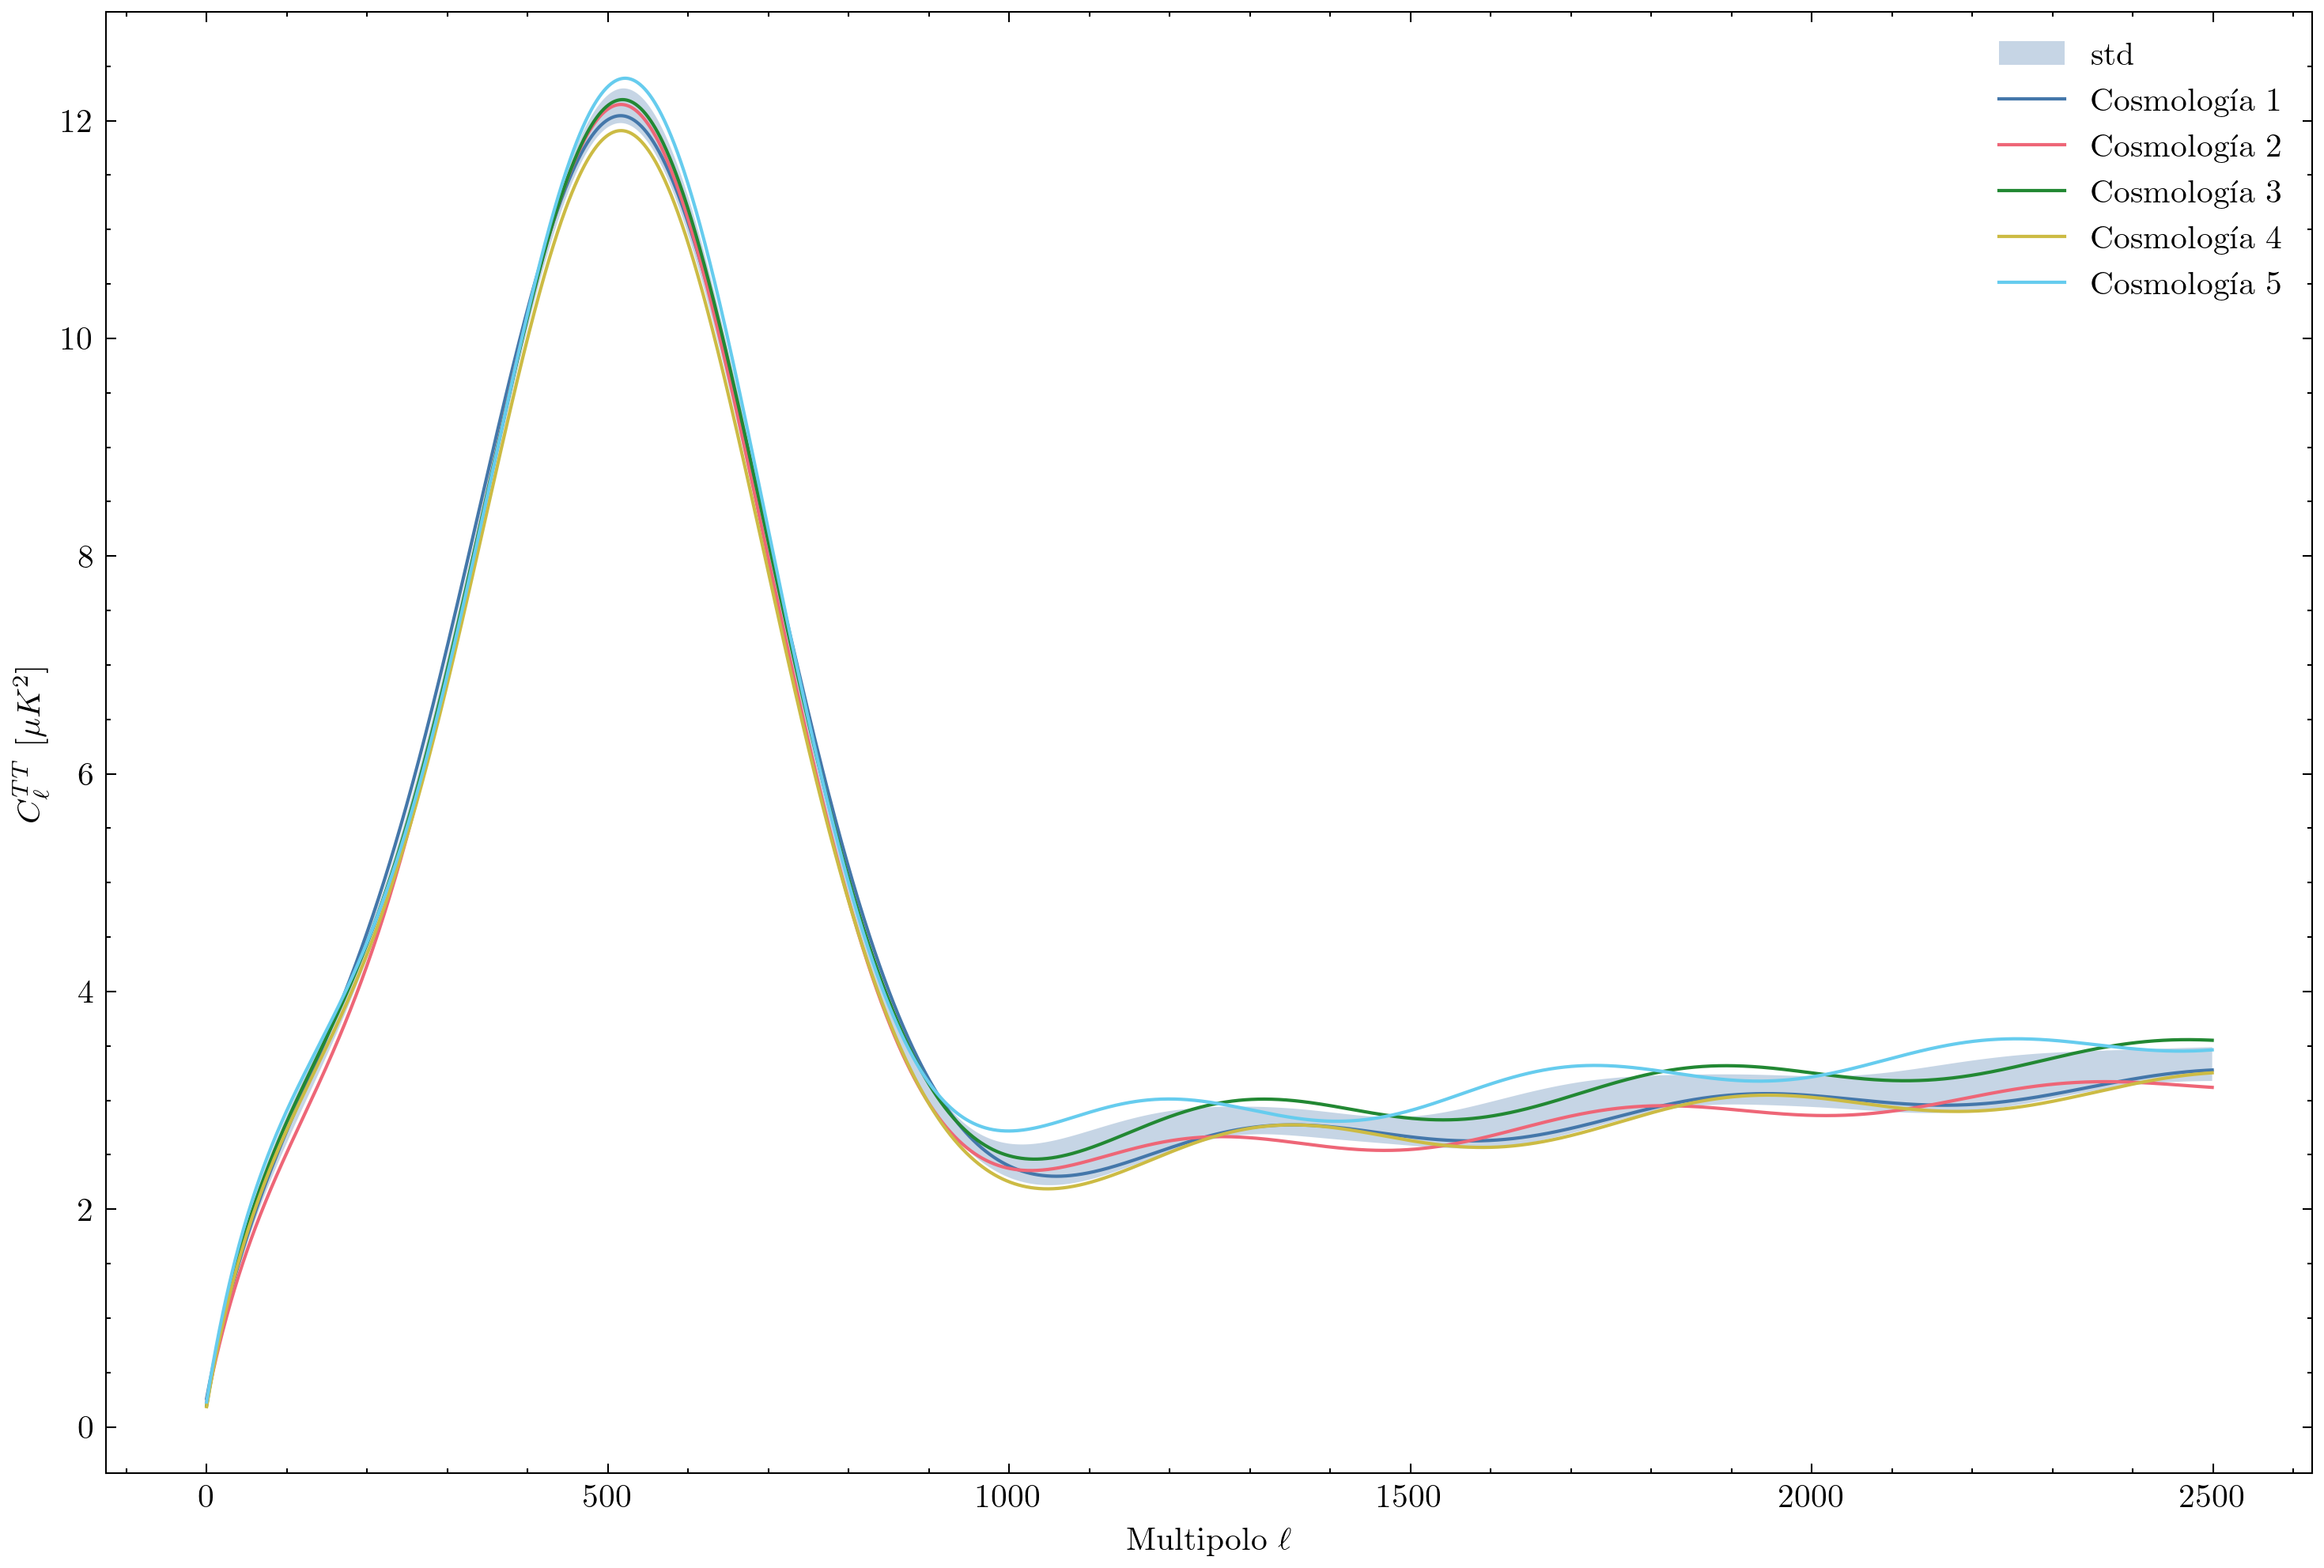

In [2]:
from src.example.synthetic import create_simulator
from src.example.synthetic import get_prior

simulator = create_simulator()
prior = get_prior()
params = prior.sample((5,))
spectra = []

print(f"Generando 1000 simulaciones...")
for theta in params:
    spectrum = simulator(theta)
    spectra.append(spectrum)
    print(f"Simulación completada")
    
spectra = torch.from_numpy(np.array(spectra))
mean_Cl = np.mean(spectra.numpy(), axis=0)
std_Cl = np.std(spectra.numpy(), axis=0)

plt.figure(figsize=(12, 8))
plt.fill_between(range(len(mean_Cl)), mean_Cl - std_Cl, mean_Cl + std_Cl, alpha=0.3, label='std')
for i in range(len(spectra)):  
    plt.plot(spectra[i, :], label=f'Cosmología {i+1}')
plt.xlabel('Multipolo $\ell$')
plt.ylabel('$C_\ell^{TT}$ [$\mu K^2$]')
plt.legend()
plt.show()

{'alpha': 10.5, 'beta': 1.75, 'gamma': 2.55, 'delta': 1.1, 'epsilon': 1.0}


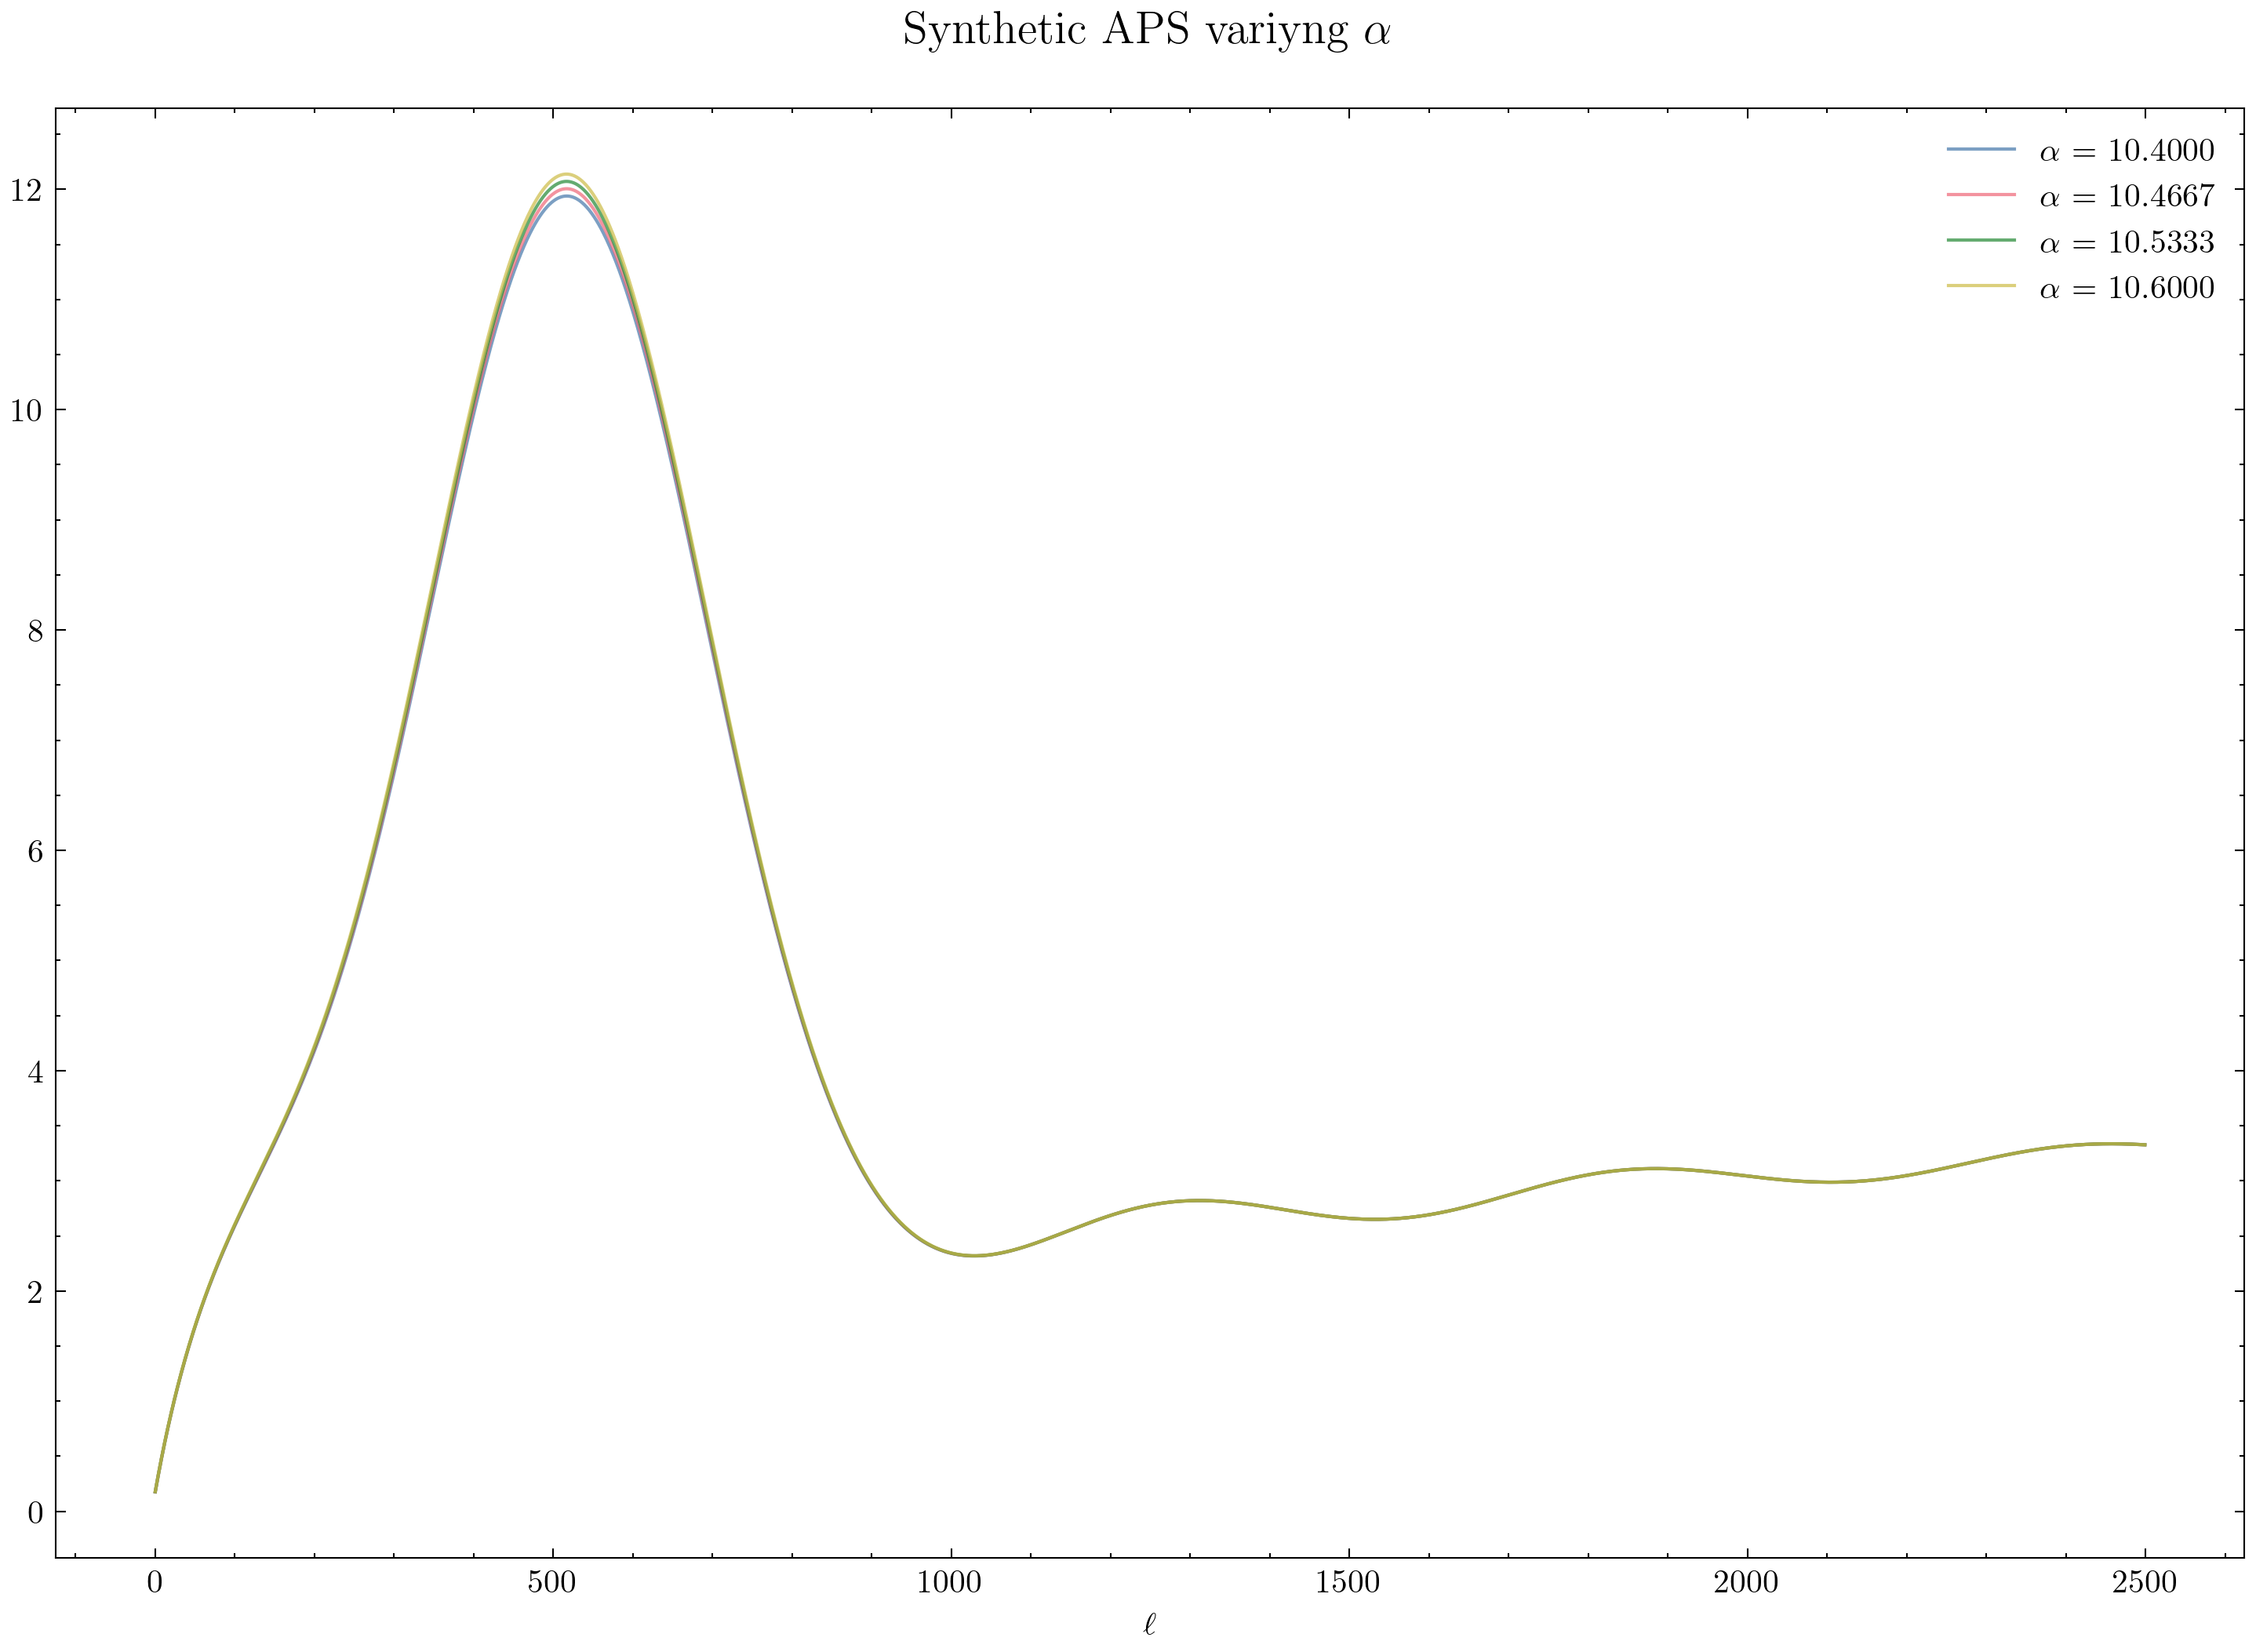

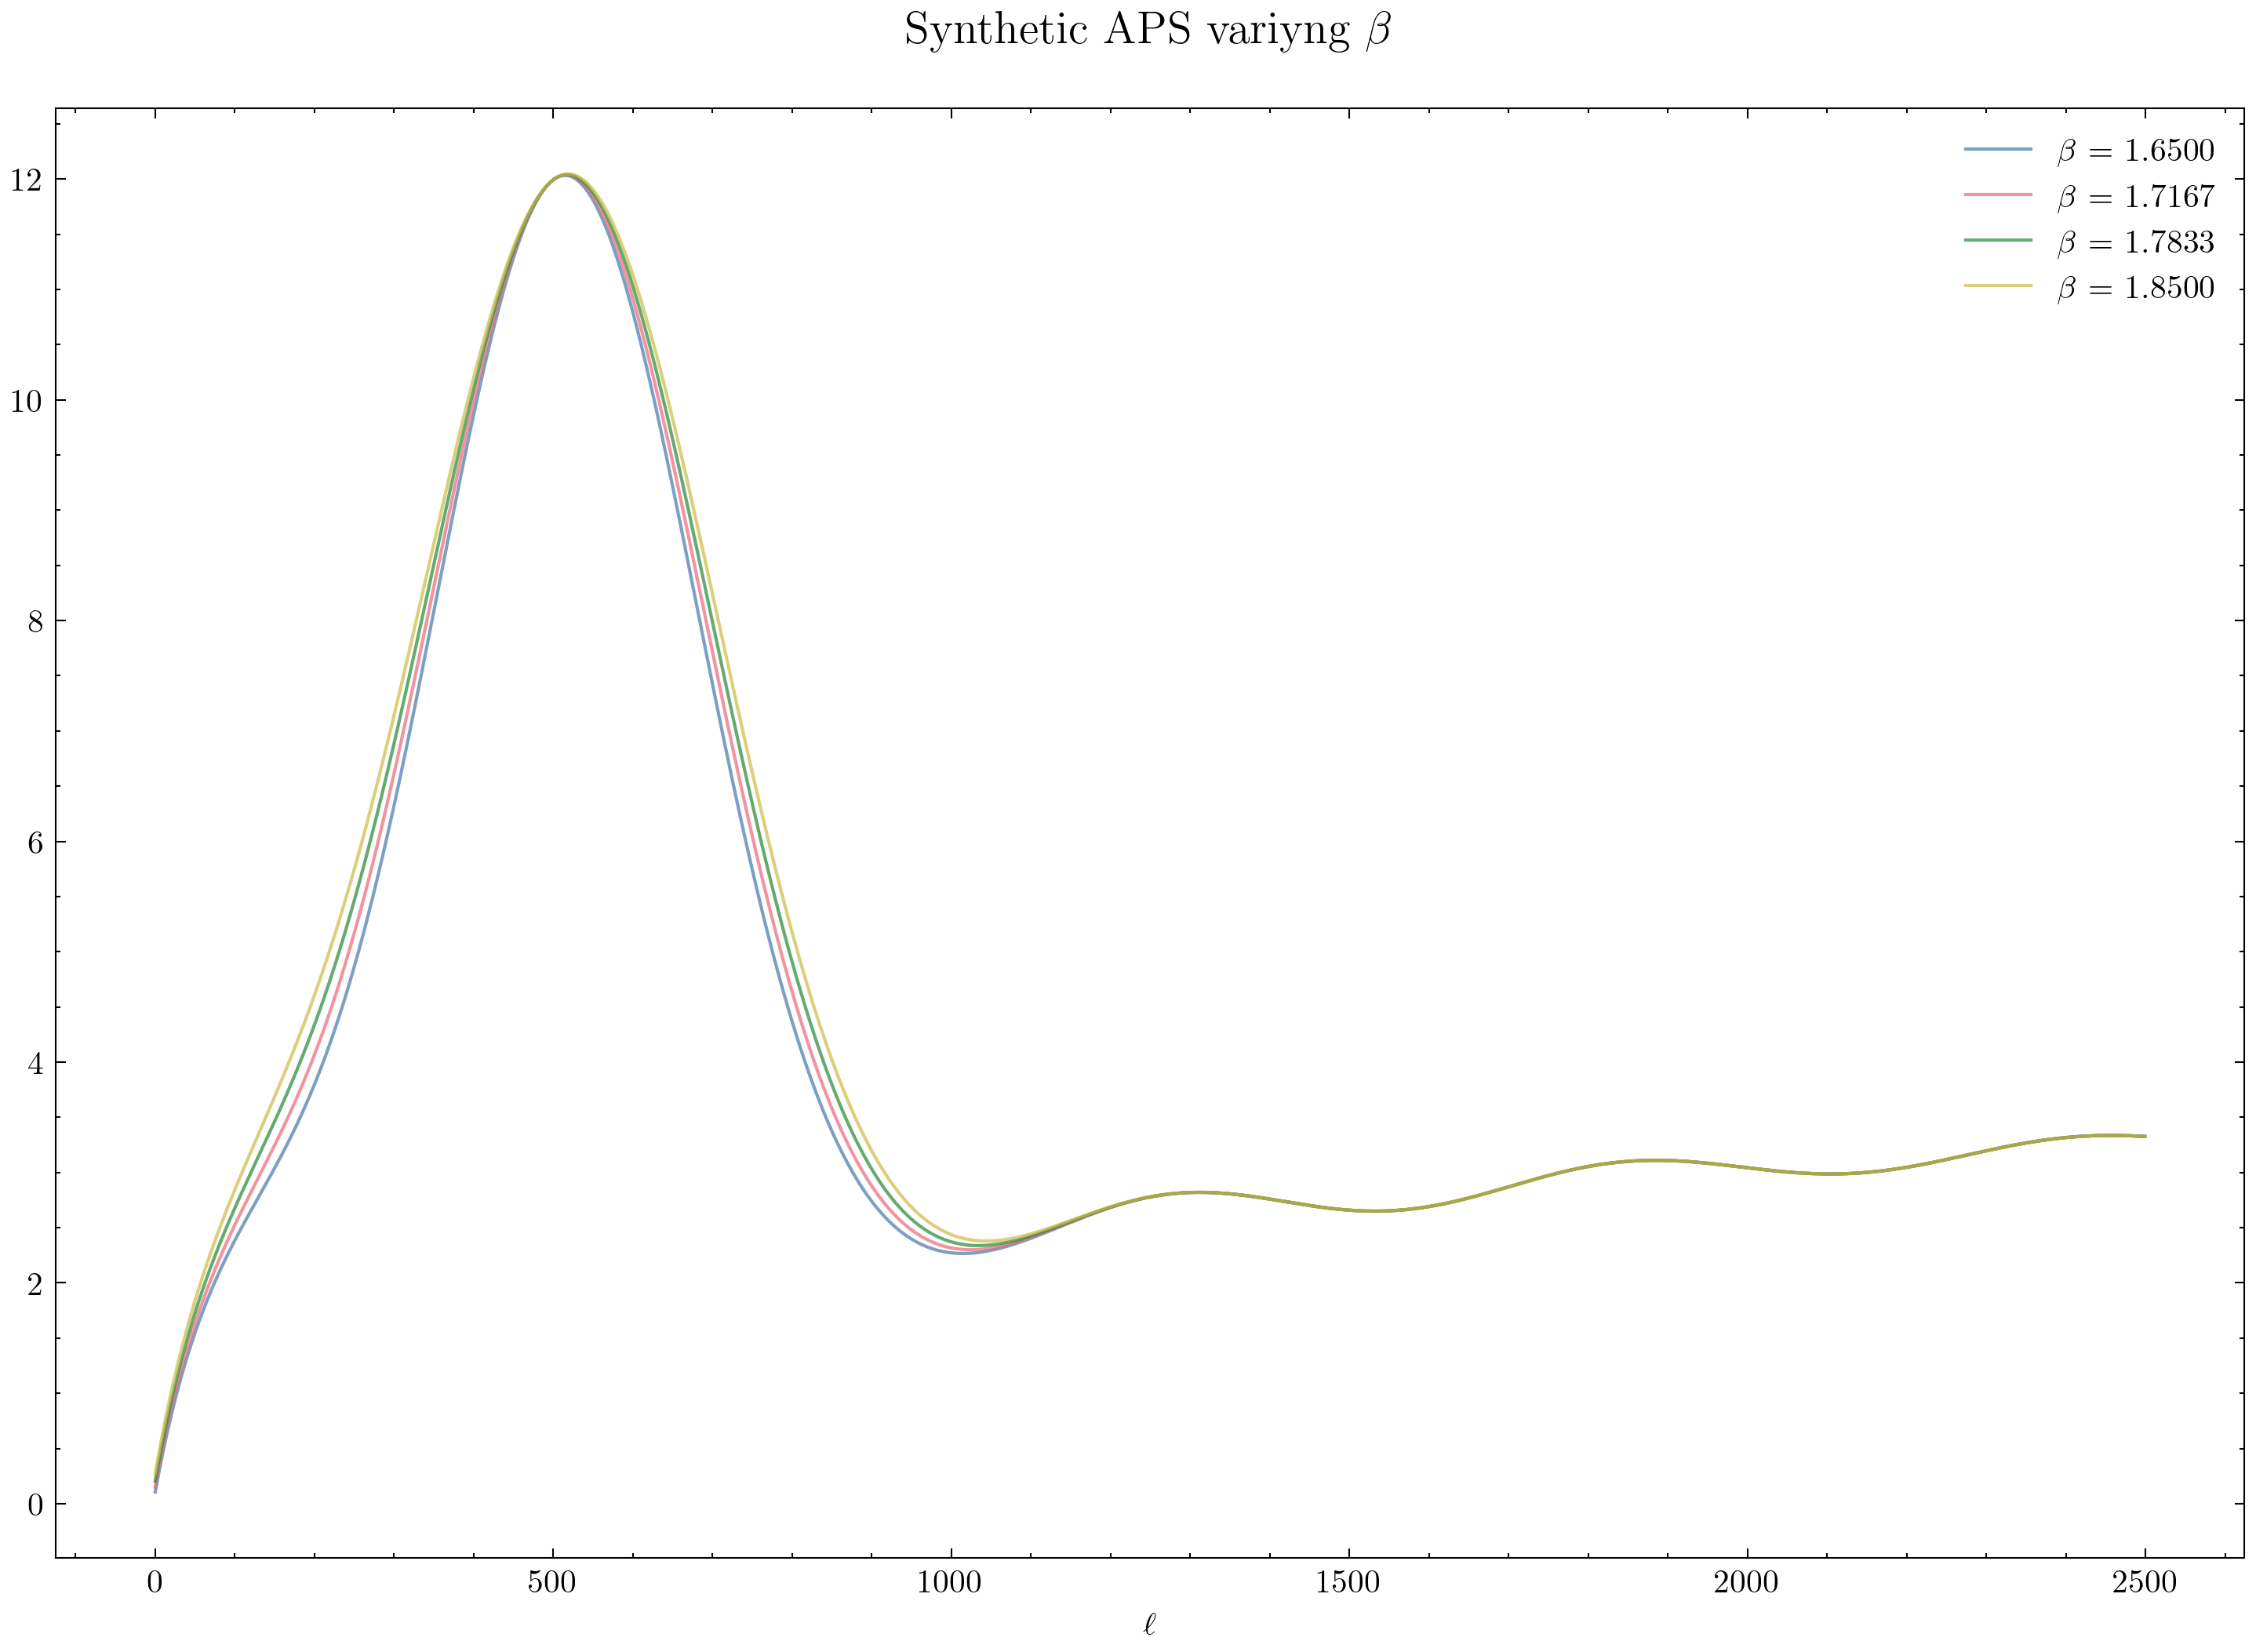

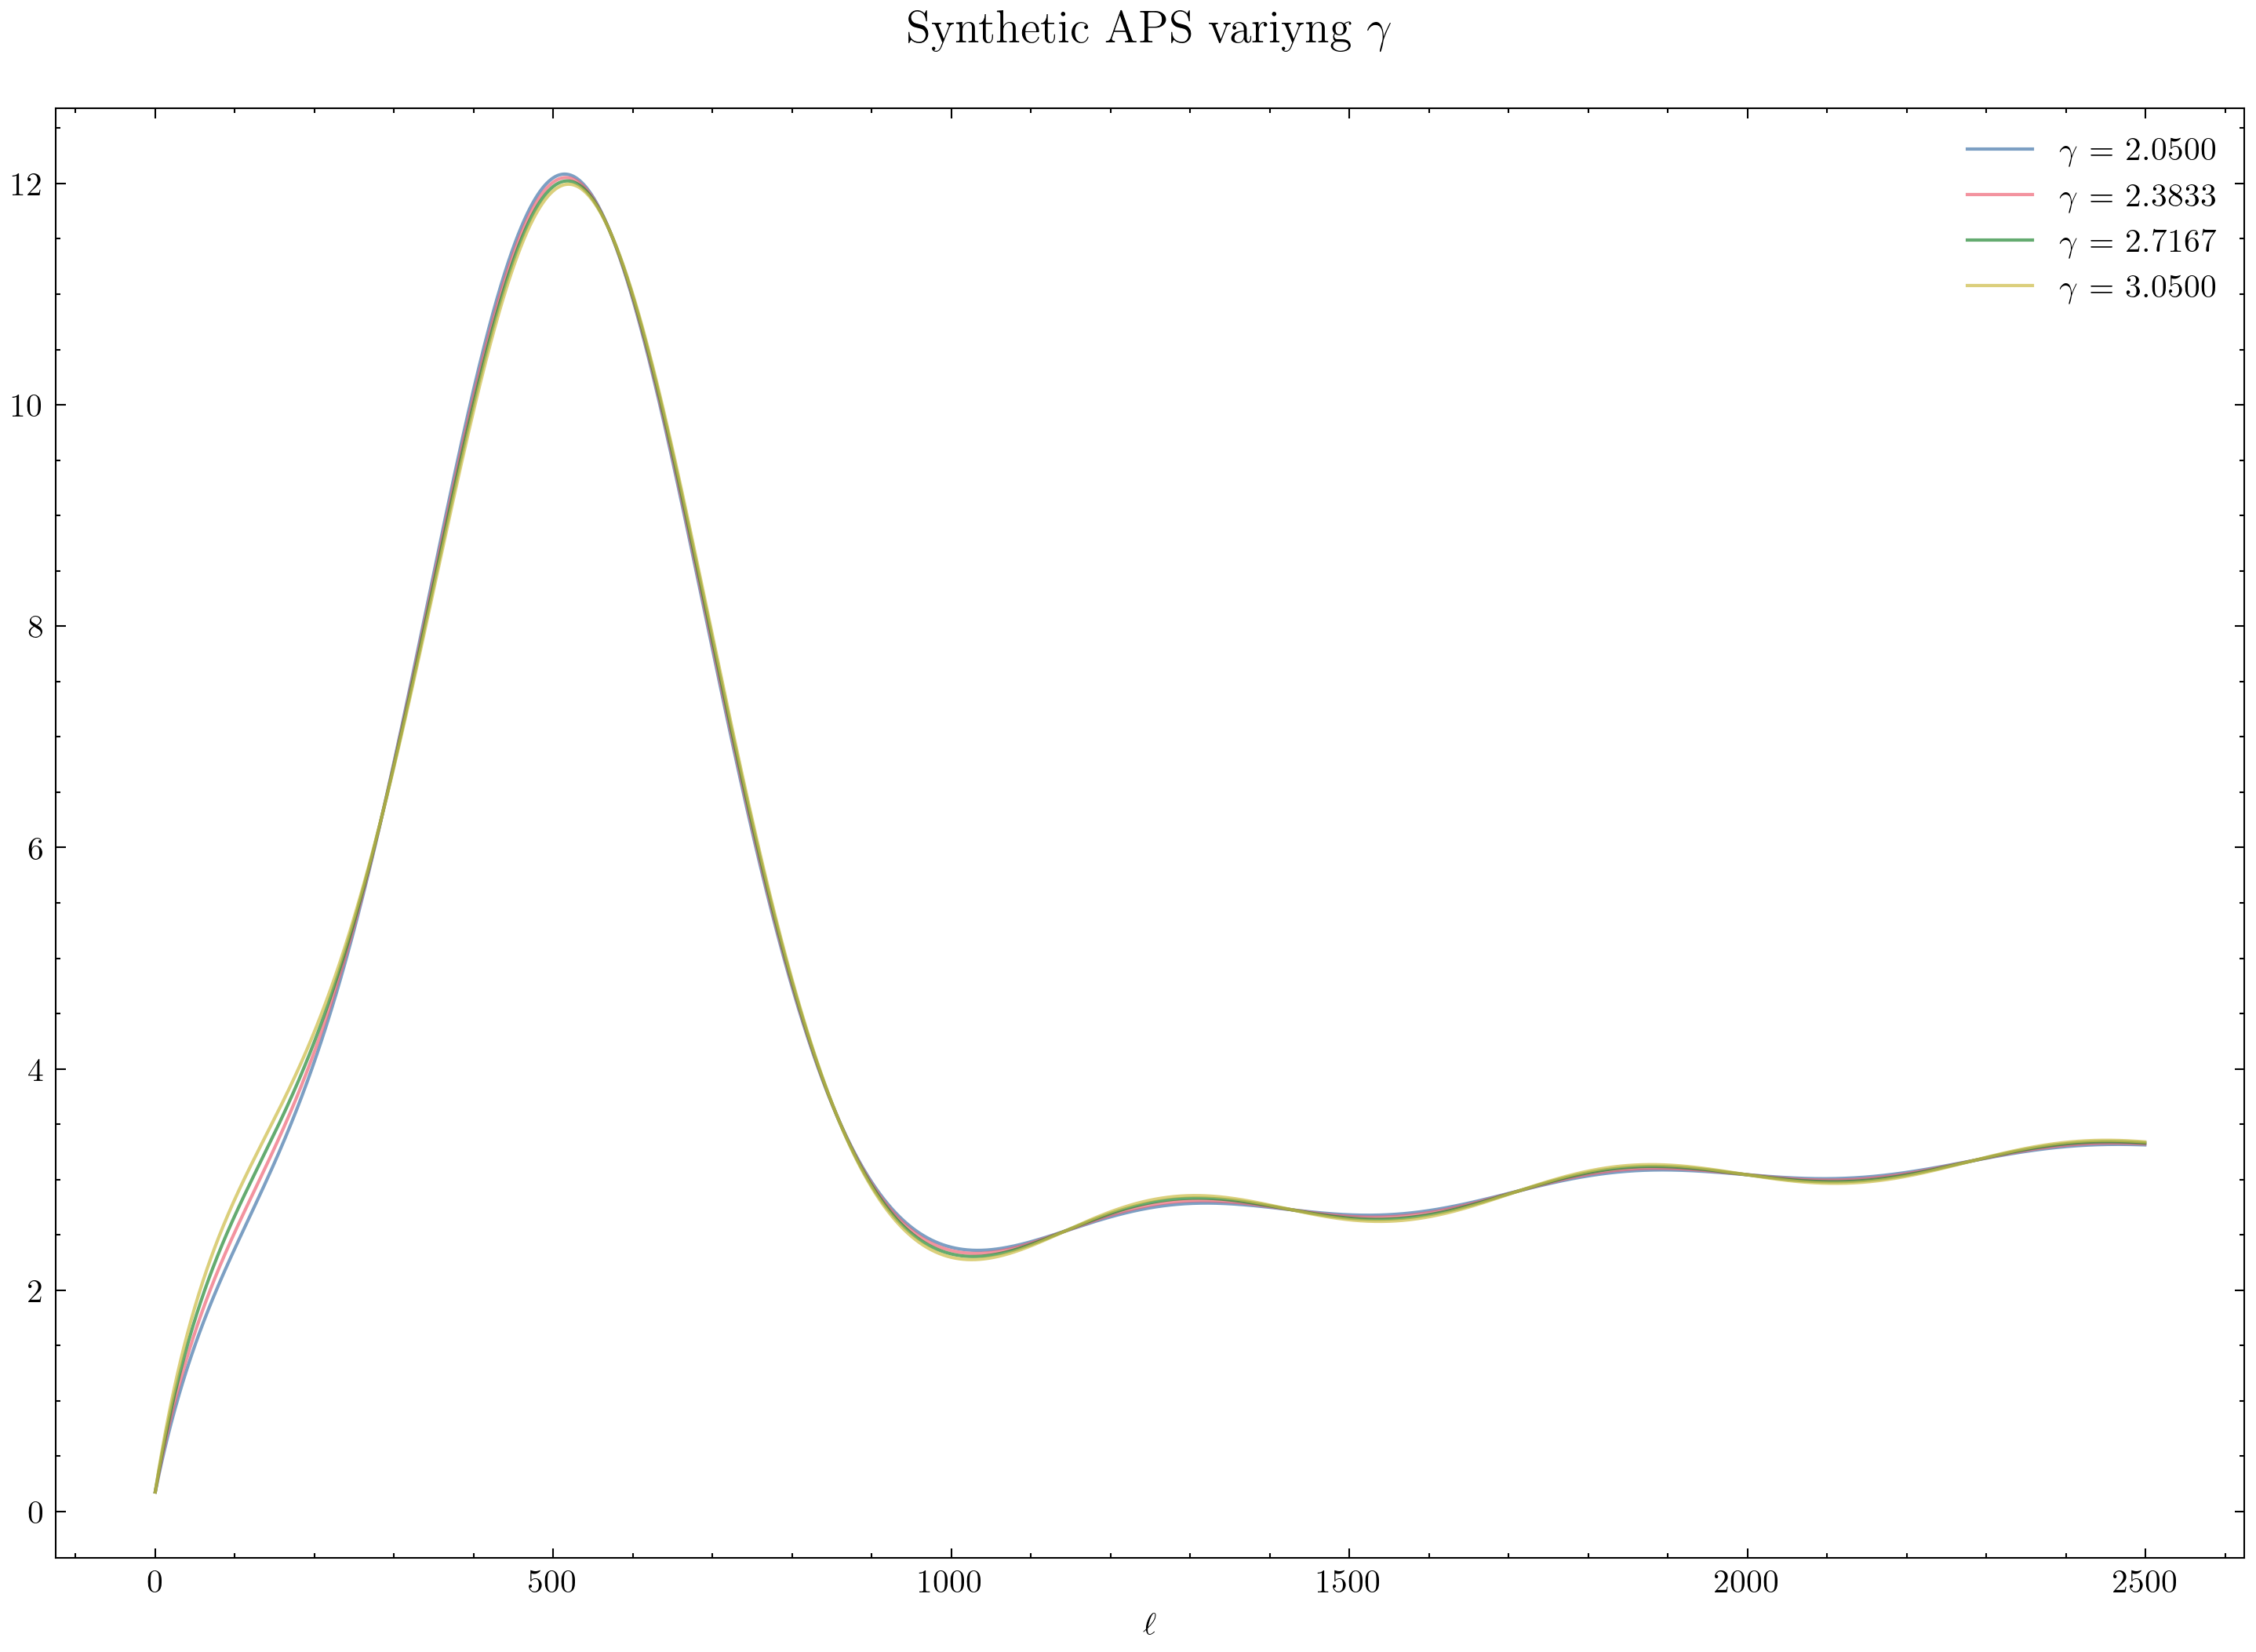

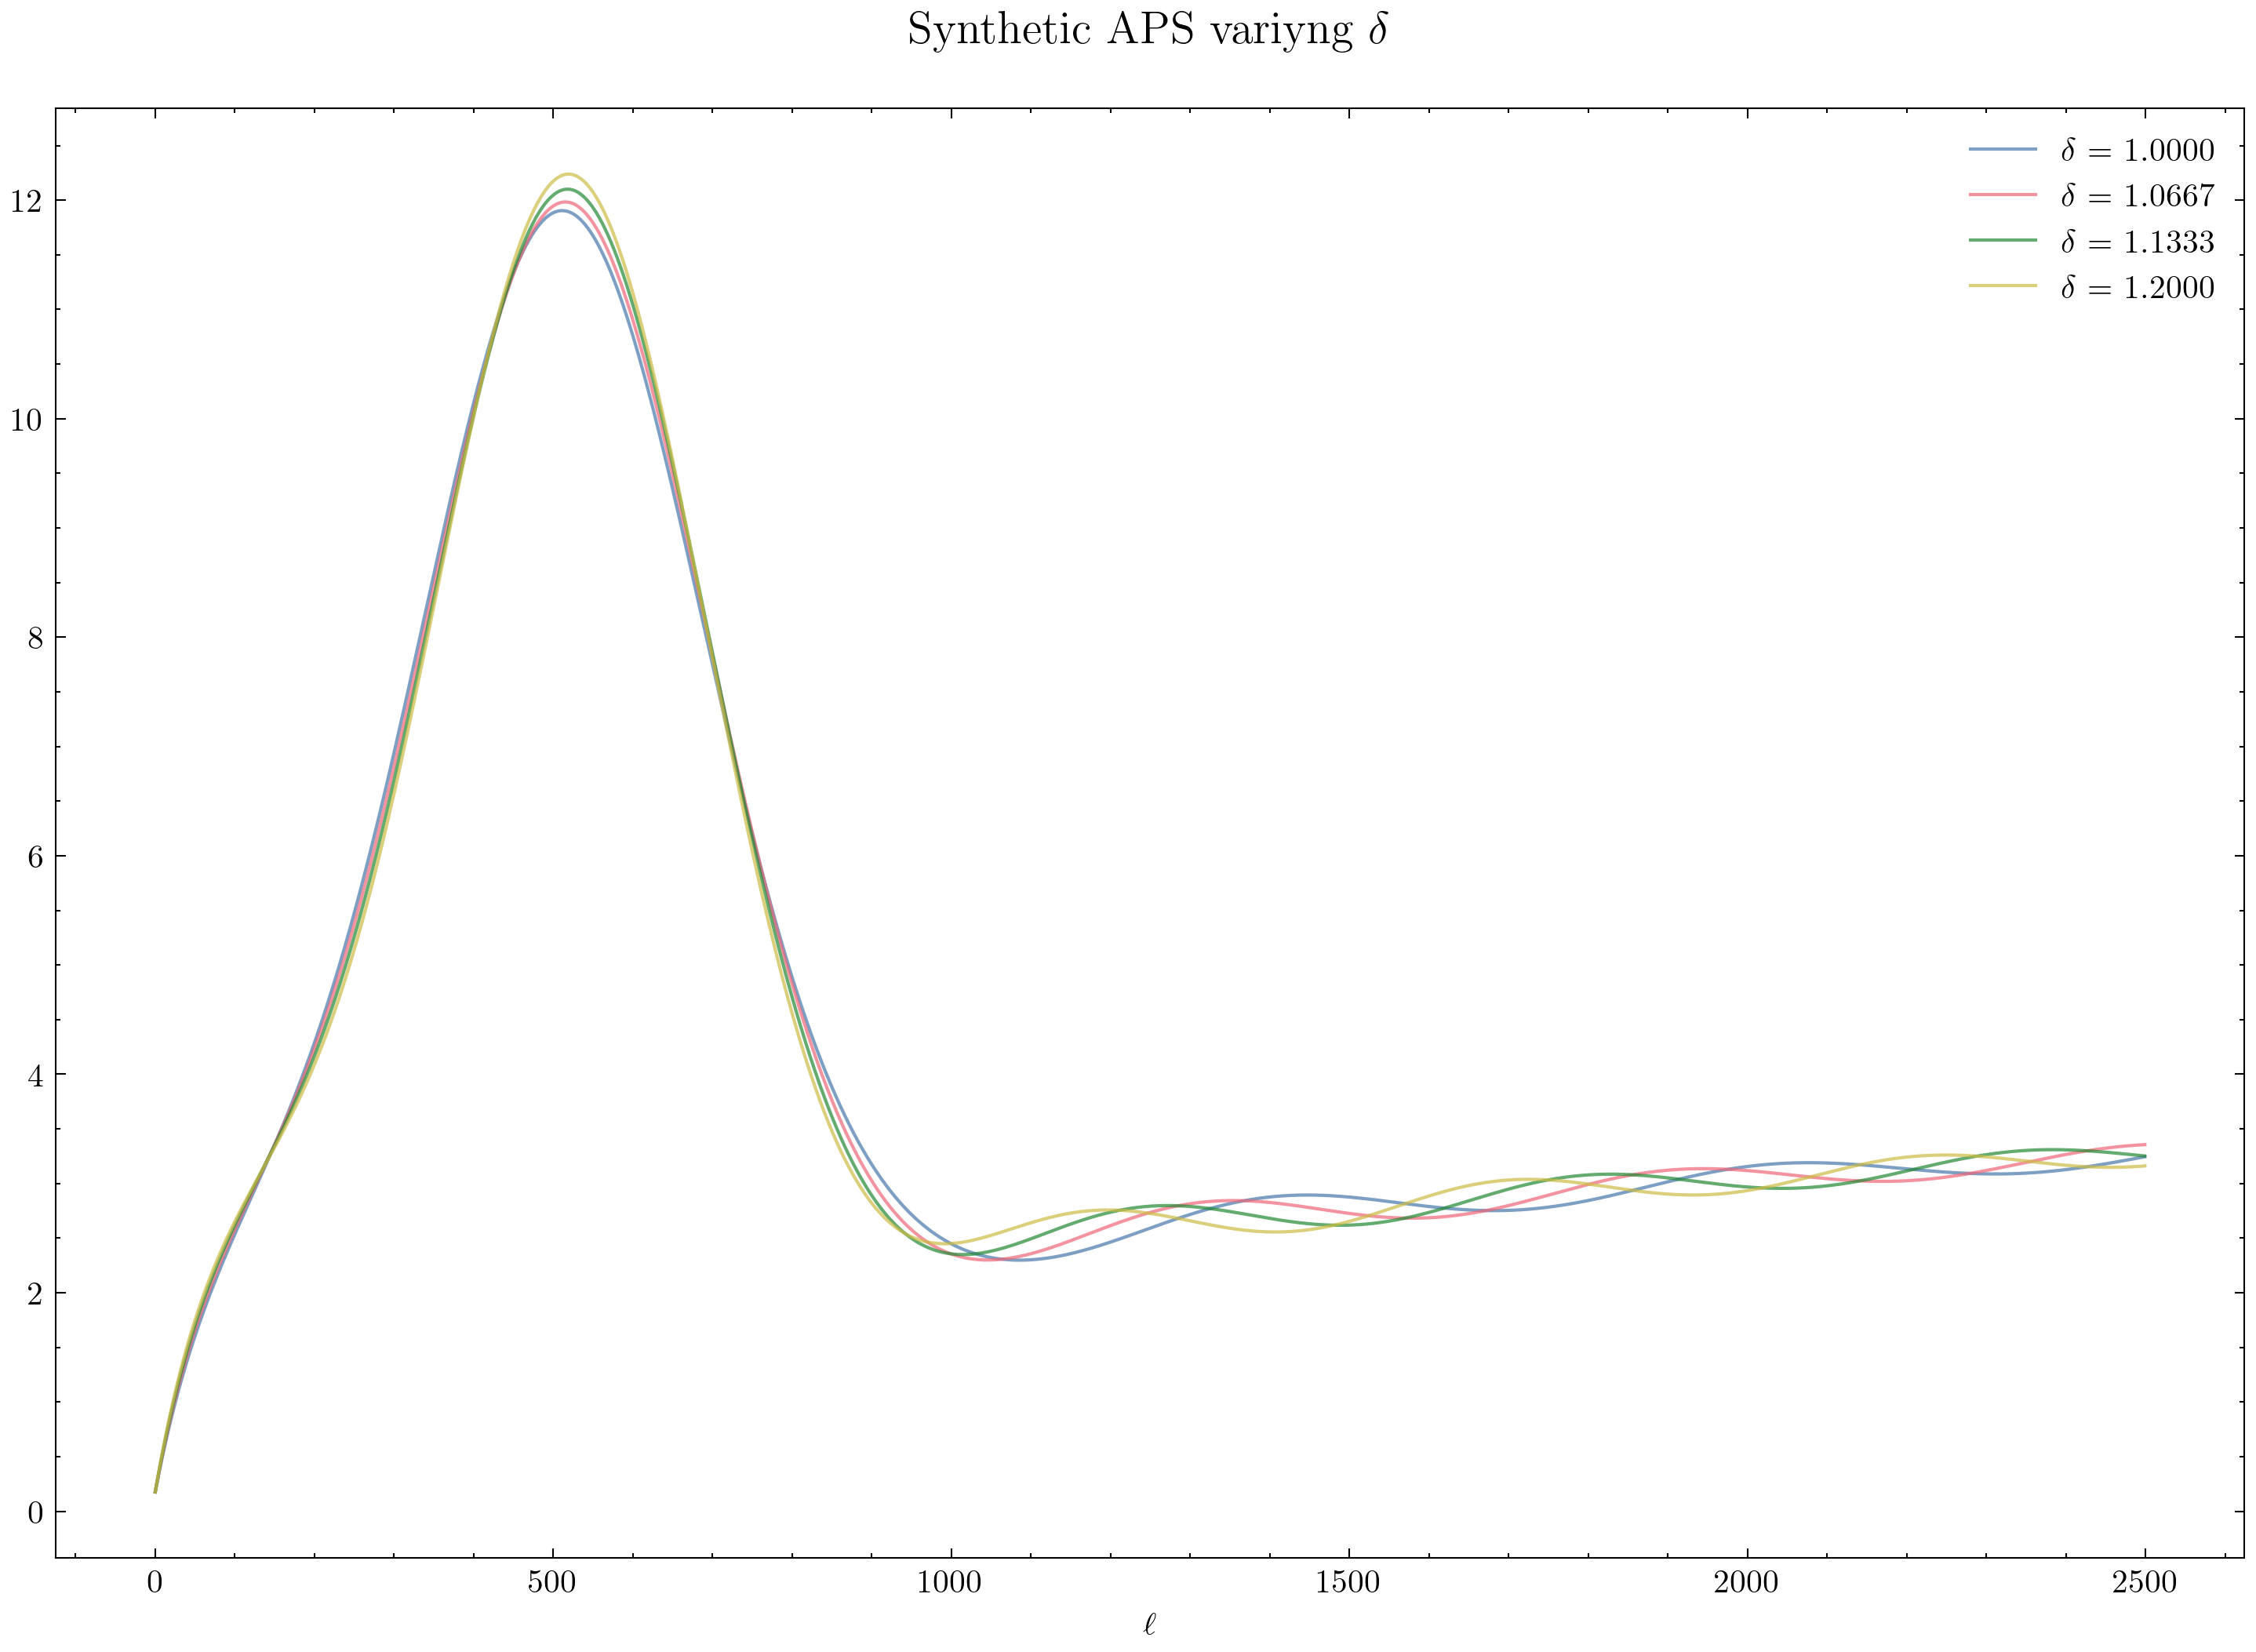

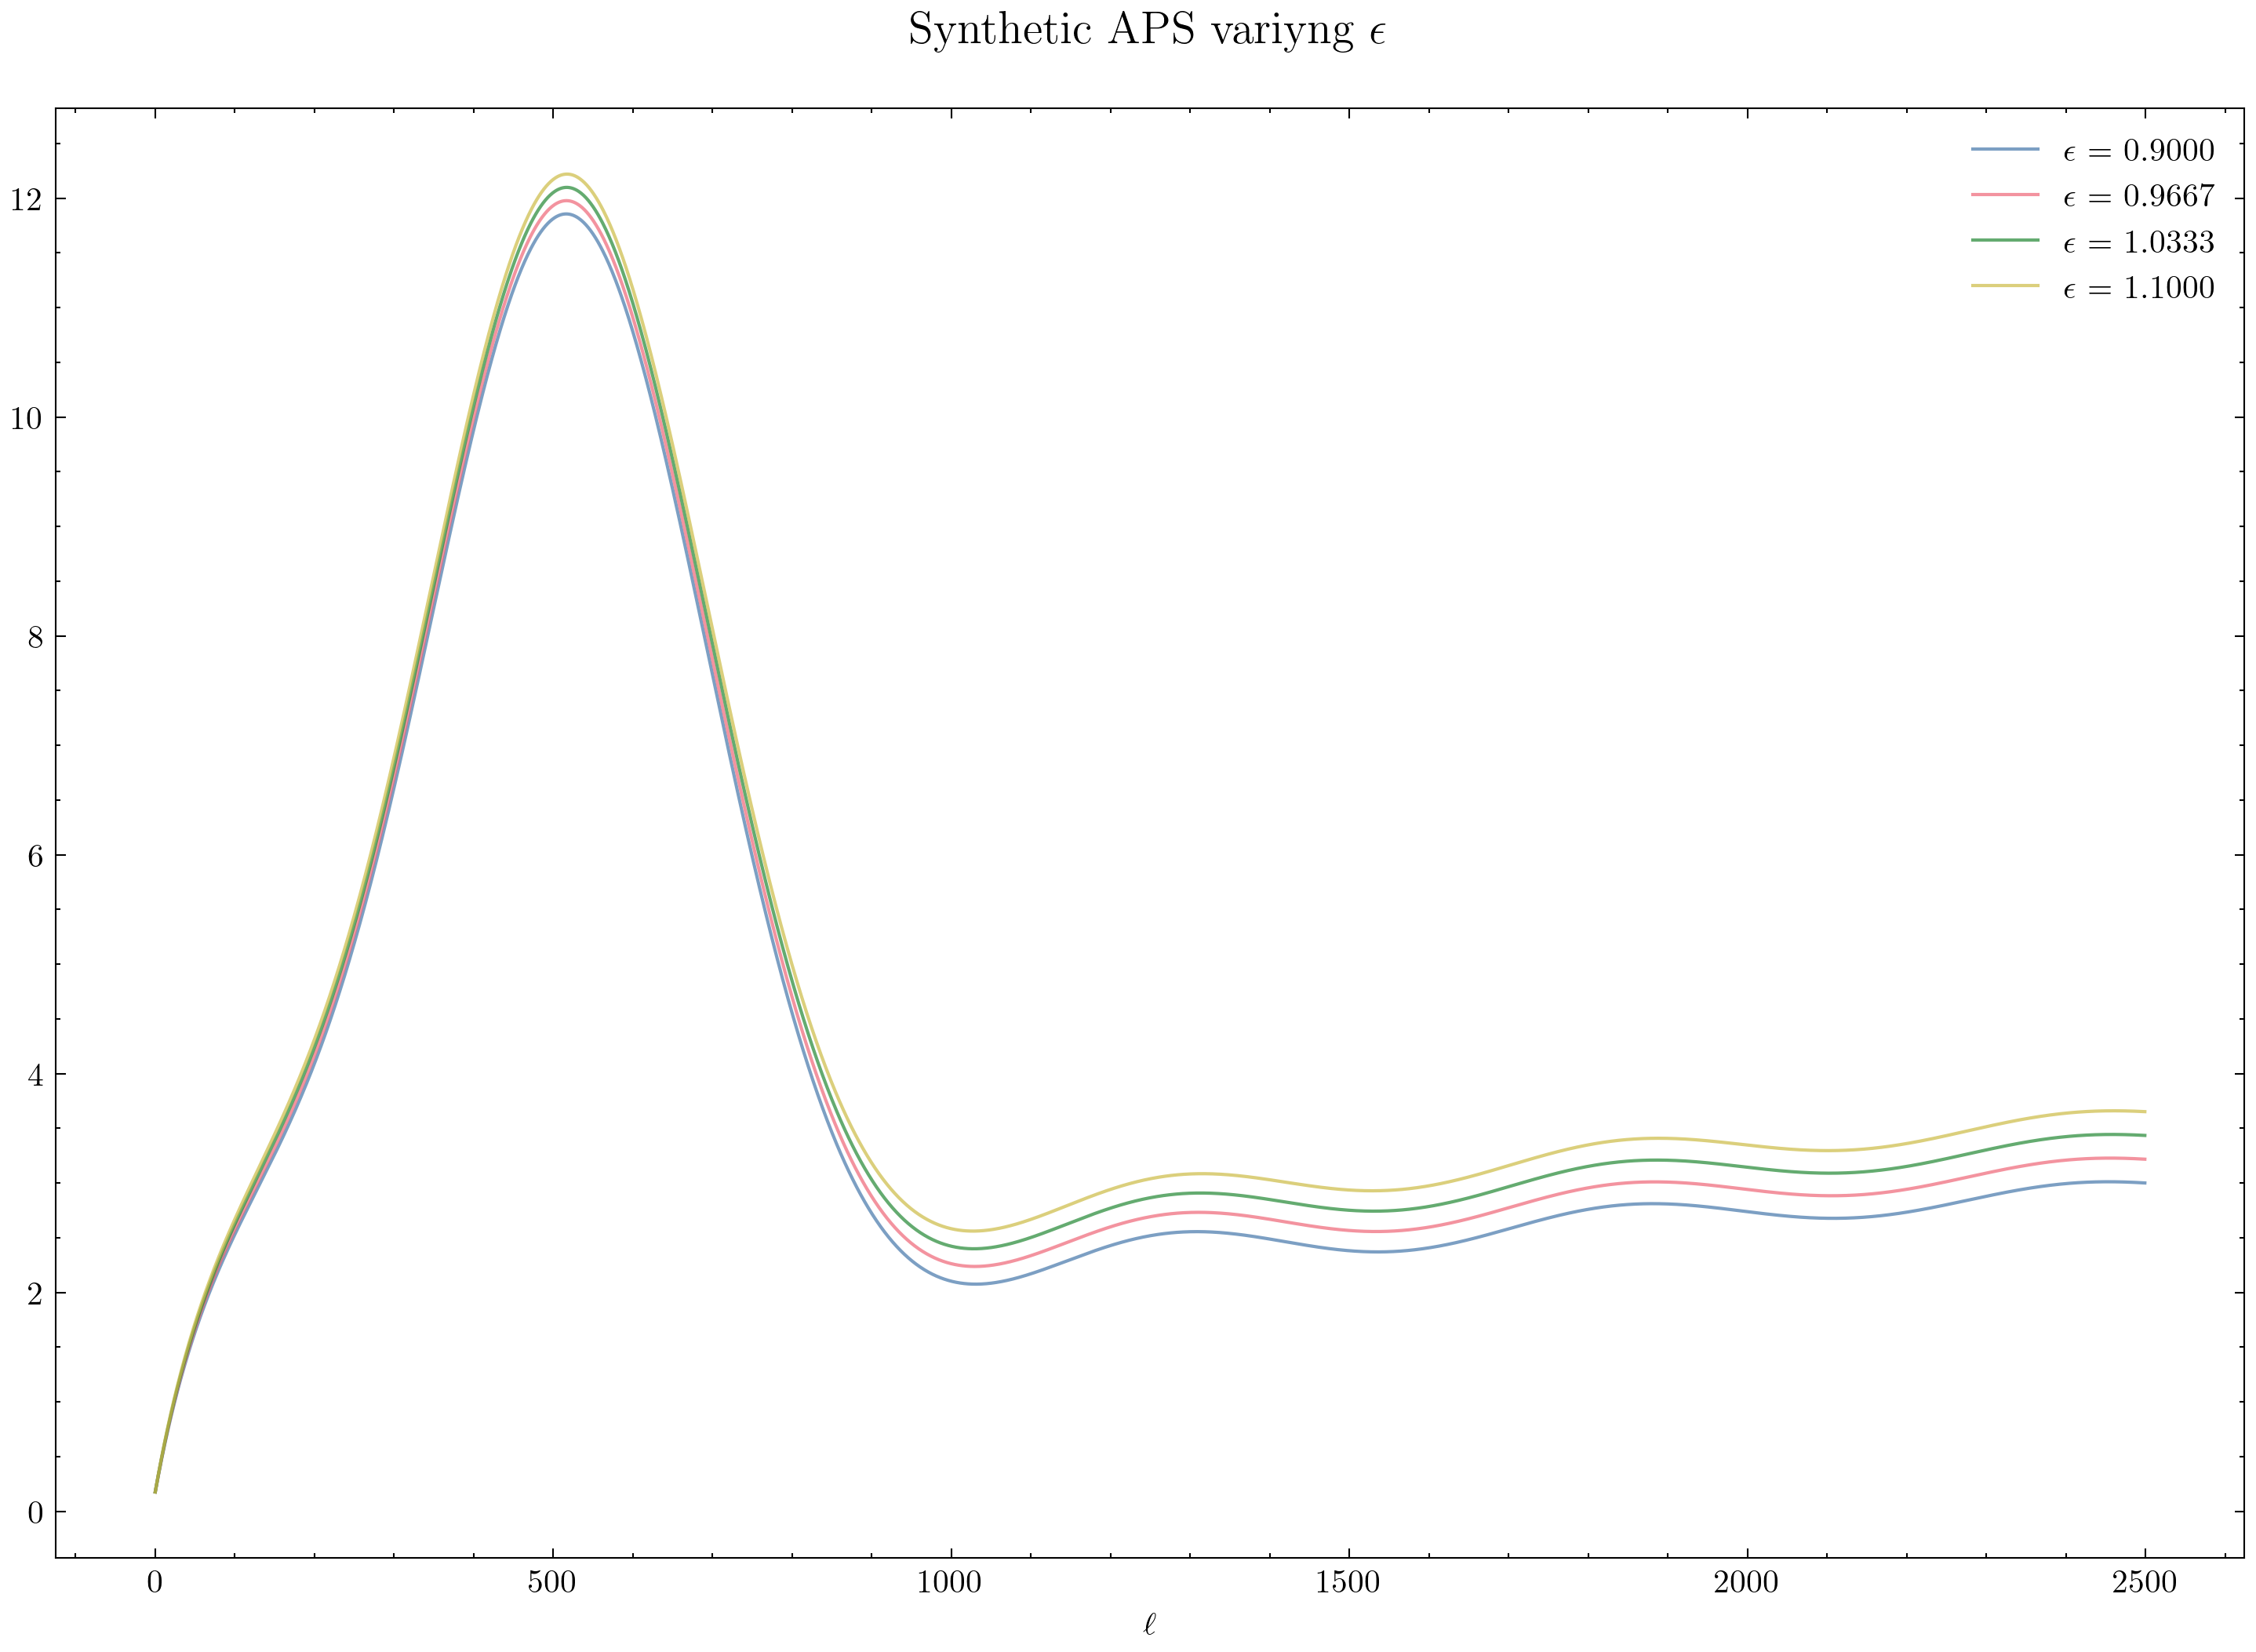

In [3]:
from src.example.synthetic import PARAM_RANGES

central_params = {k: (v[0] + v[1])/2 for k, v in PARAM_RANGES.items()}
n_values = 4 

params_order = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_latex = {'alpha': r'$\alpha$',
    'beta': r'$\beta$',
    'gamma': r'$\gamma$',
    'delta': r'$\delta$',
    'epsilon': r'$\epsilon$'
}

print(central_params)

def plot_varying_param(simulator):
    for param_name in params_order:
        plt.figure(figsize=(12, 8))
        param_values = np.linspace(PARAM_RANGES[param_name][0], PARAM_RANGES[param_name][1], n_values)
        
        for i, val in enumerate(param_values):
            current_params = central_params.copy()
            current_params[param_name] = val
            param_list = [current_params[p] for p in params_order]
            spectrum = simulator(param_list) 
            
            plt.plot(spectrum, label=f'{param_latex[param_name]} = {val:.4f}', alpha=0.7)
        
        plt.title(f'Synthetic APS variyng {param_latex[param_name]}', fontsize=14, pad=20)
        plt.xlabel('$\ell$')
        plt.legend()
        plt.show()

plot_varying_param(simulator=simulator)

c:\users\julian\documents\cmb-sbi-inference\src\inference\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)
Drawing 25000 posterior samples:

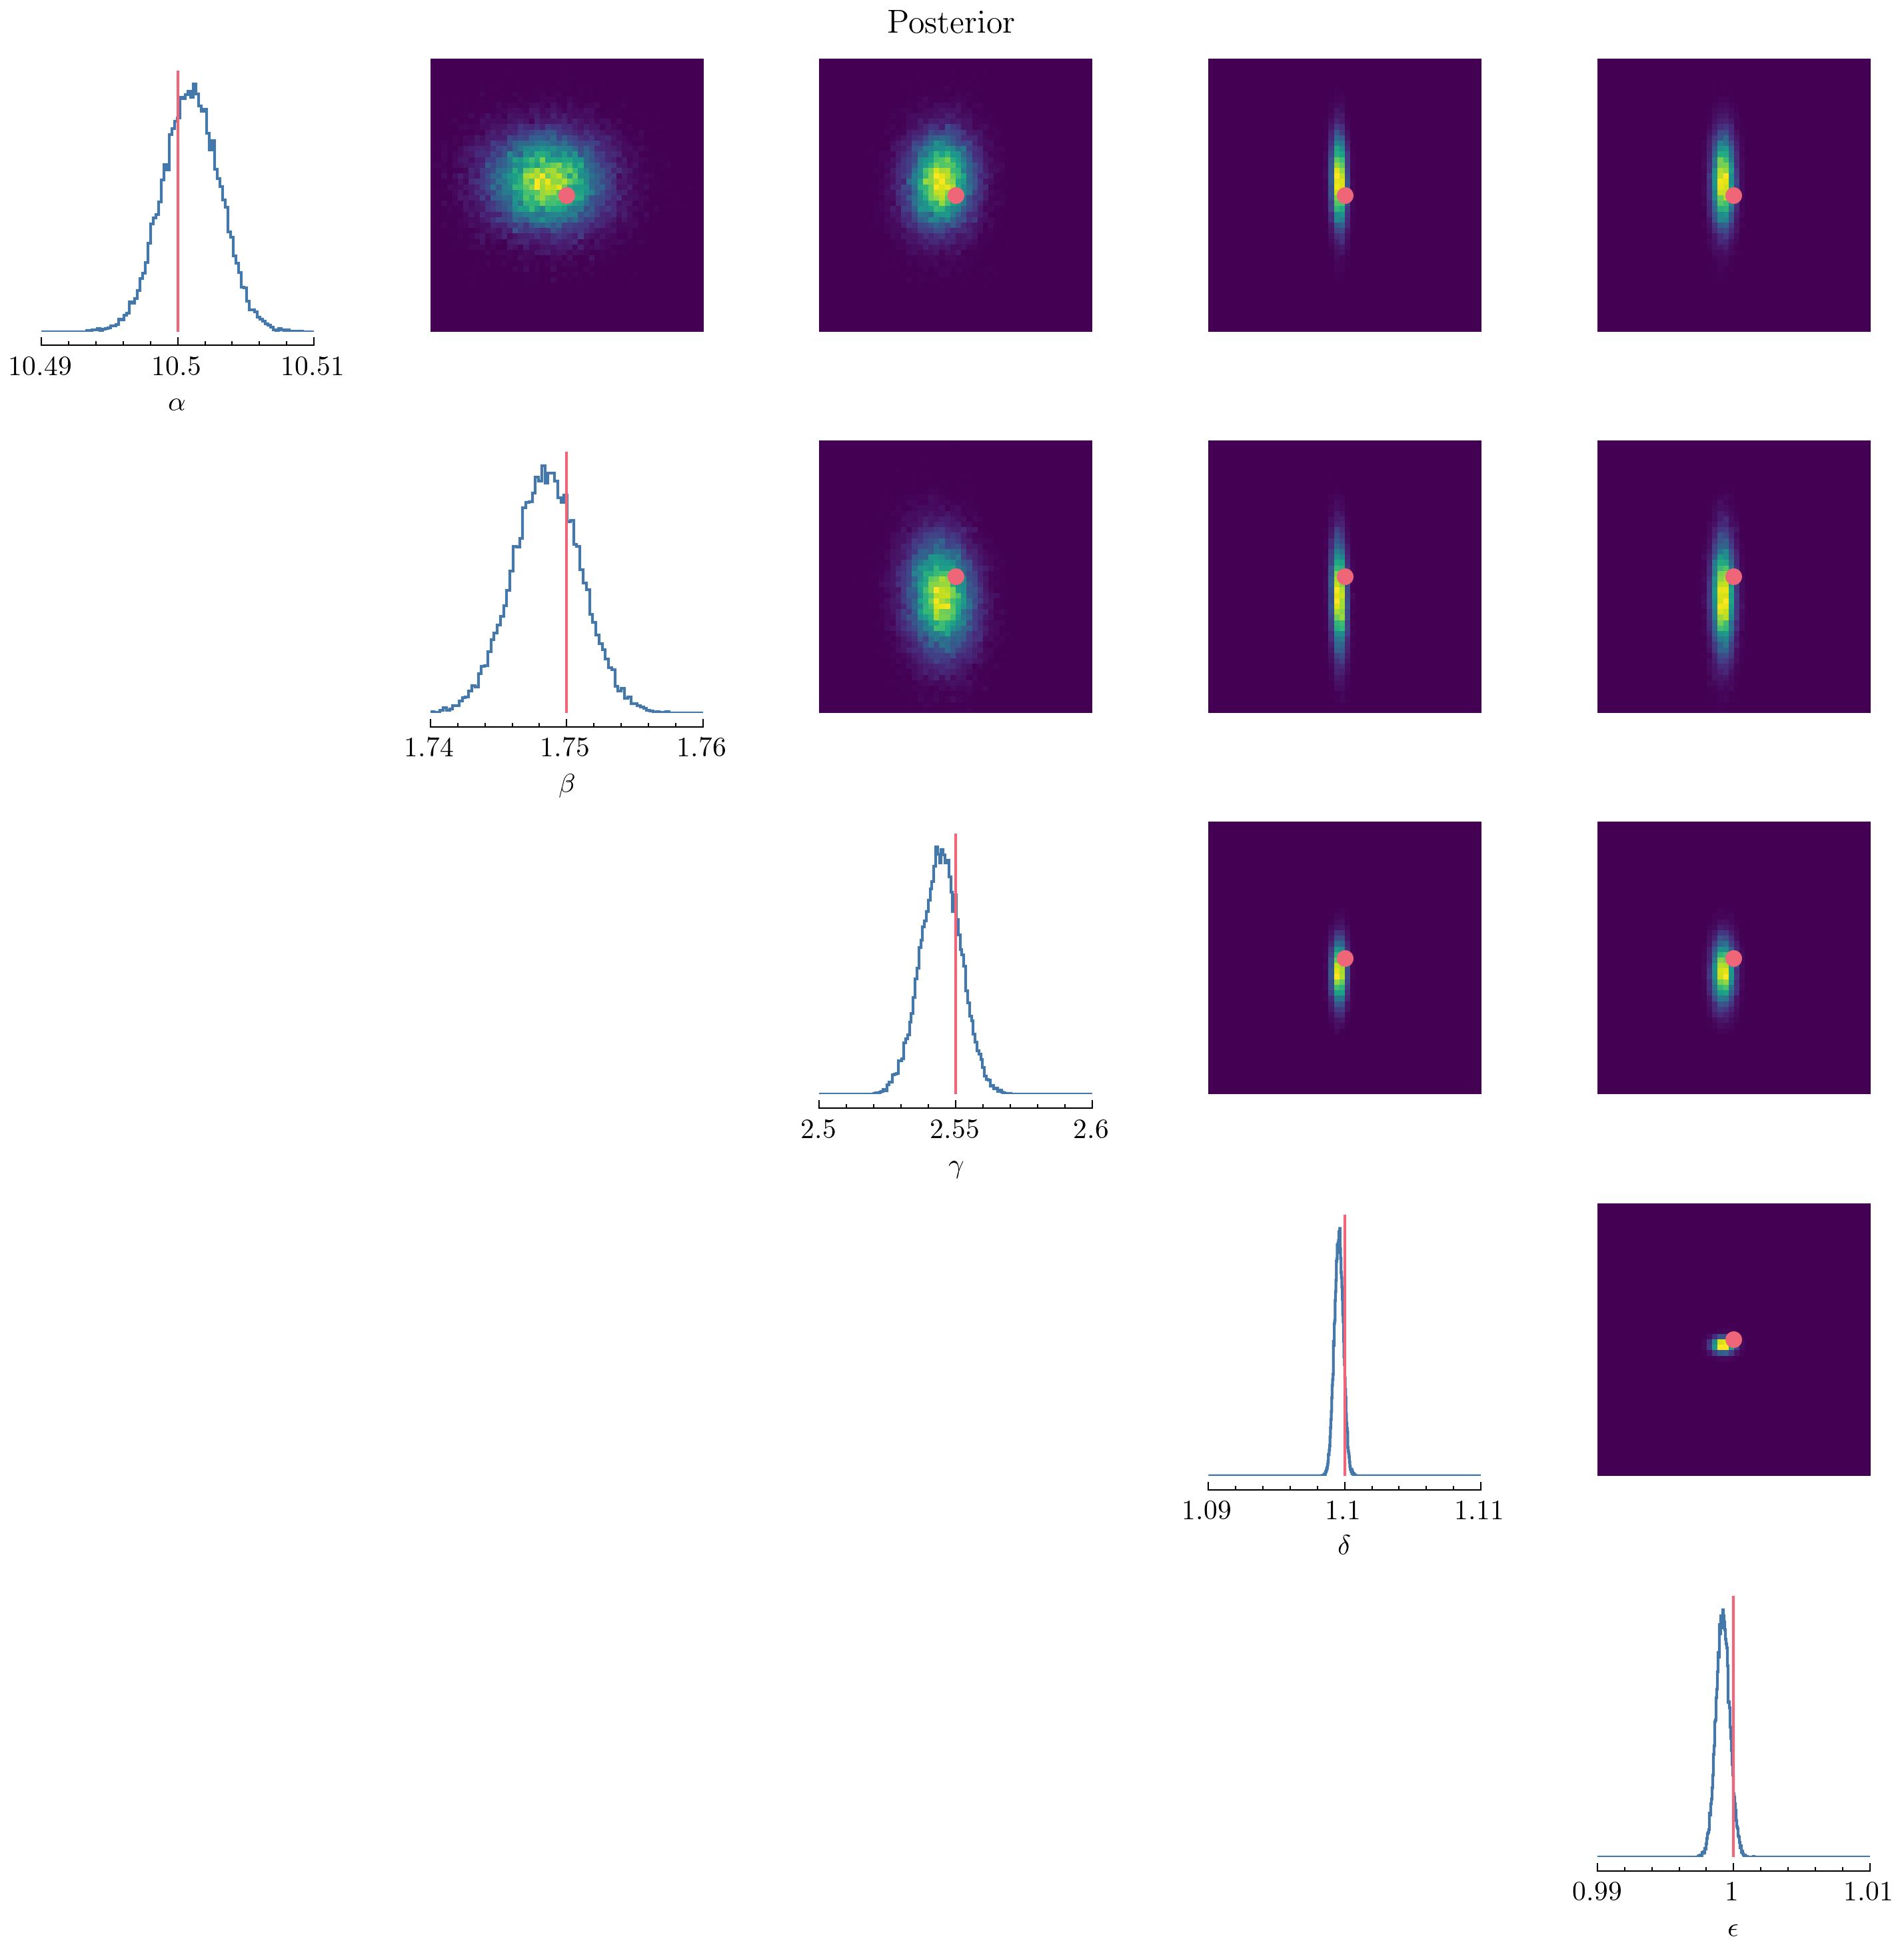

In [4]:
from src.inference.utils import load_model
from sbi.analysis import pairplot
from sbi.inference import SNPE_C

density_estimator = load_model(os.path.join("..", "results", "synthetic", "model_5000.pkl"))
inference = SNPE_C(prior=prior)

posterior = inference.build_posterior(density_estimator)  
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
x_observed = simulator(true_parameter)
samples = posterior.set_default_x(x_observed).sample((25000,))

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.5-0.01, 10.5+0.01],    
    [1.75-0.01, 1.75+0.01],  
    [2.55-0.05, 2.55+0.05],      
    [1.1-0.01, 1.1+0.01],    
    [1-0.01, 1+0.01],  
])
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

In [8]:
from sbi.diagnostics import run_tarp
from sbi.inference import SNPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

prior, _, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)

inference = SNPE_C(prior=prior)
posterior = inference.build_posterior(density_estimator)
thetas, xs = simulate_for_sbi(simulator_wrapper, proposal=prior, num_simulations=200, seed=0)

ecp, alpha = run_tarp(thetas, xs, posterior, references=None, num_posterior_samples=1000, use_batched_sampling=False, num_workers=4)

Sampling 200 times (1000,) posterior samples.: 100%|██████████| 200/200 [00:17<00:00, 11.20it/s]


(<Figure size 1800x1800 with 1 Axes>,
 <Axes: xlabel='Credibility Level $\\alpha$', ylabel='Expected Coverage Probability'>)

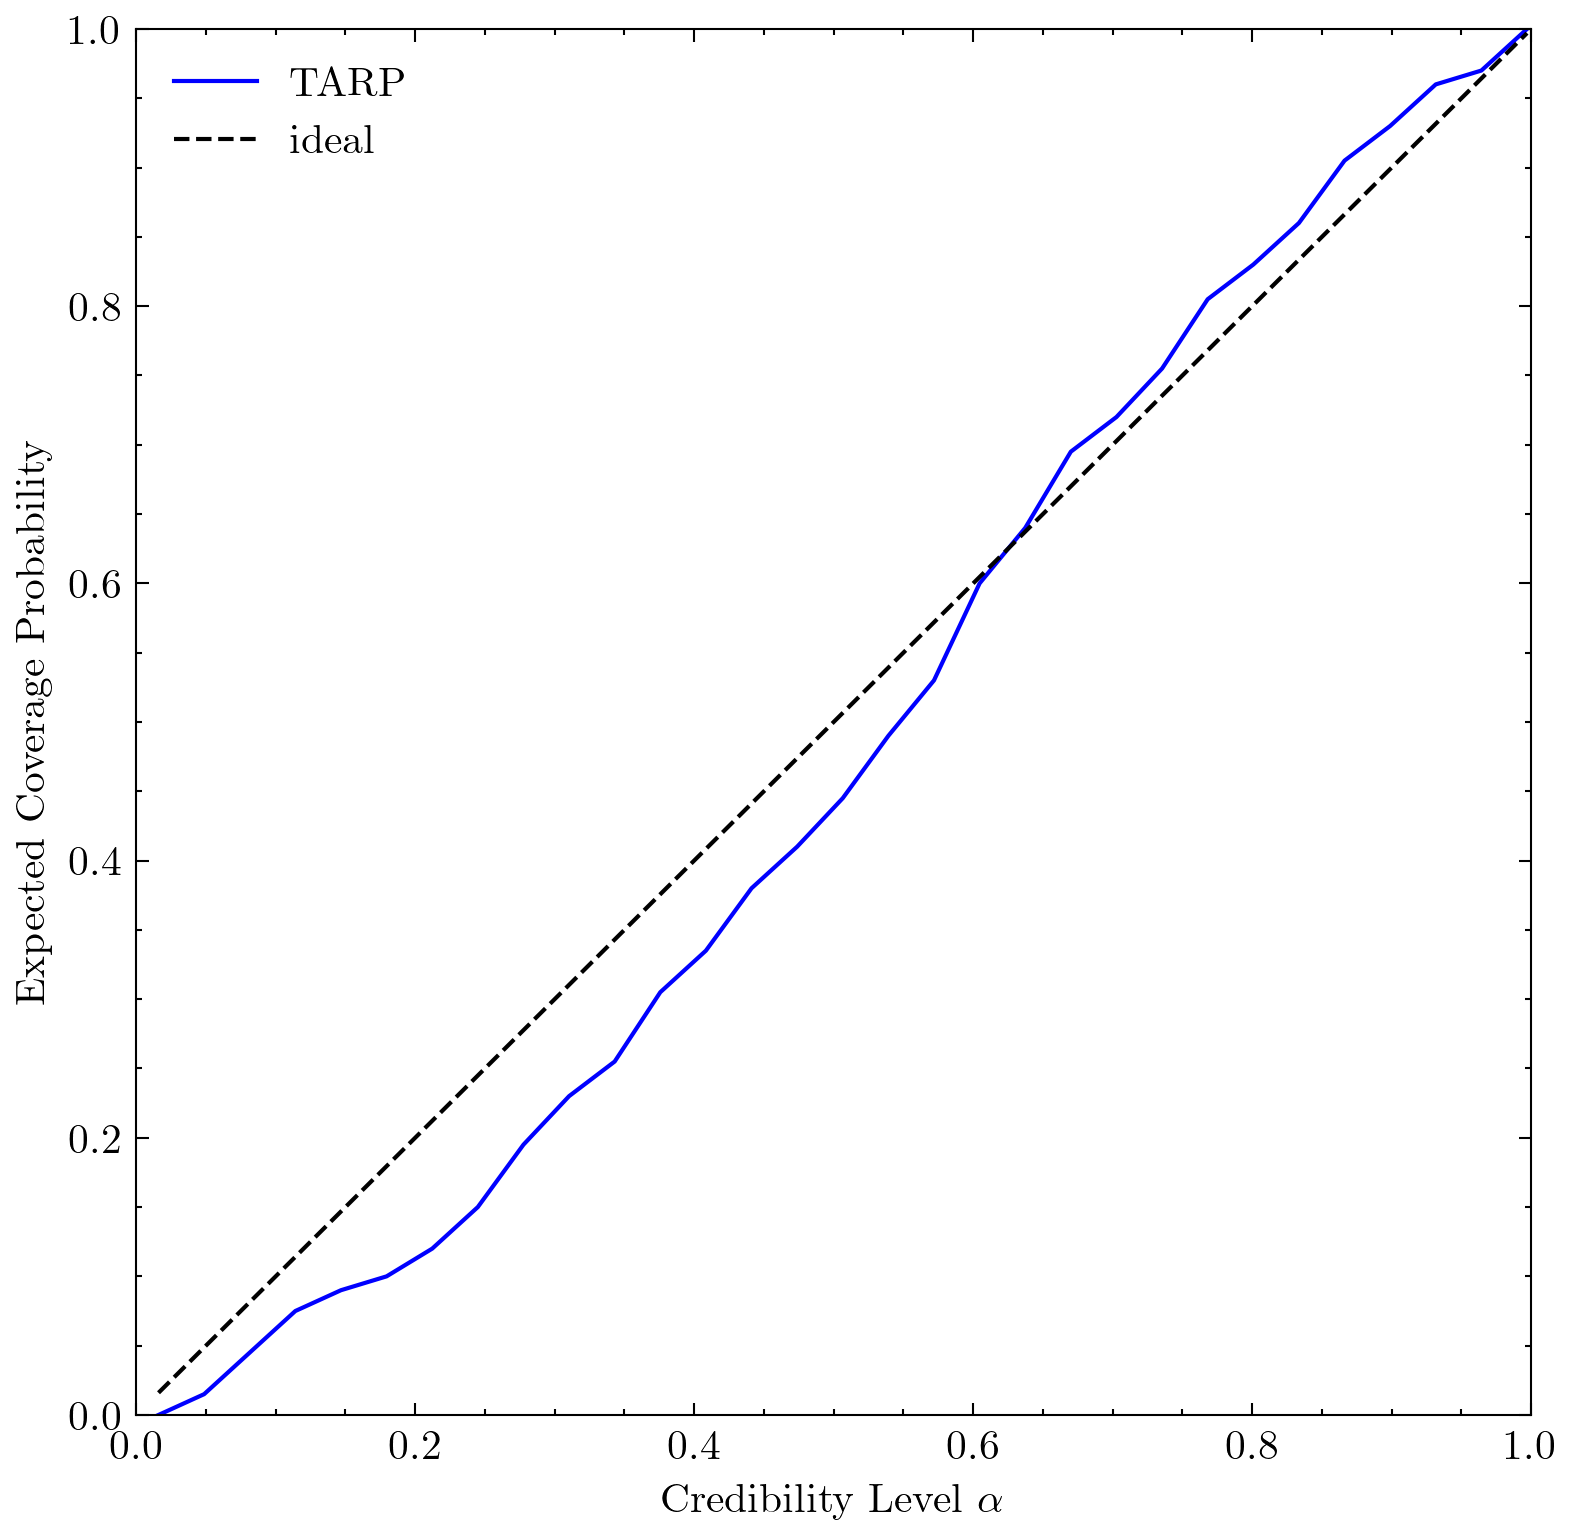

In [ ]:
from sbi.analysis.plot import plot_tarp

plot_tarp(ecp, alpha)

Drawing 25000 posterior samples: 27500it [00:01, 24003.53it/s]                           


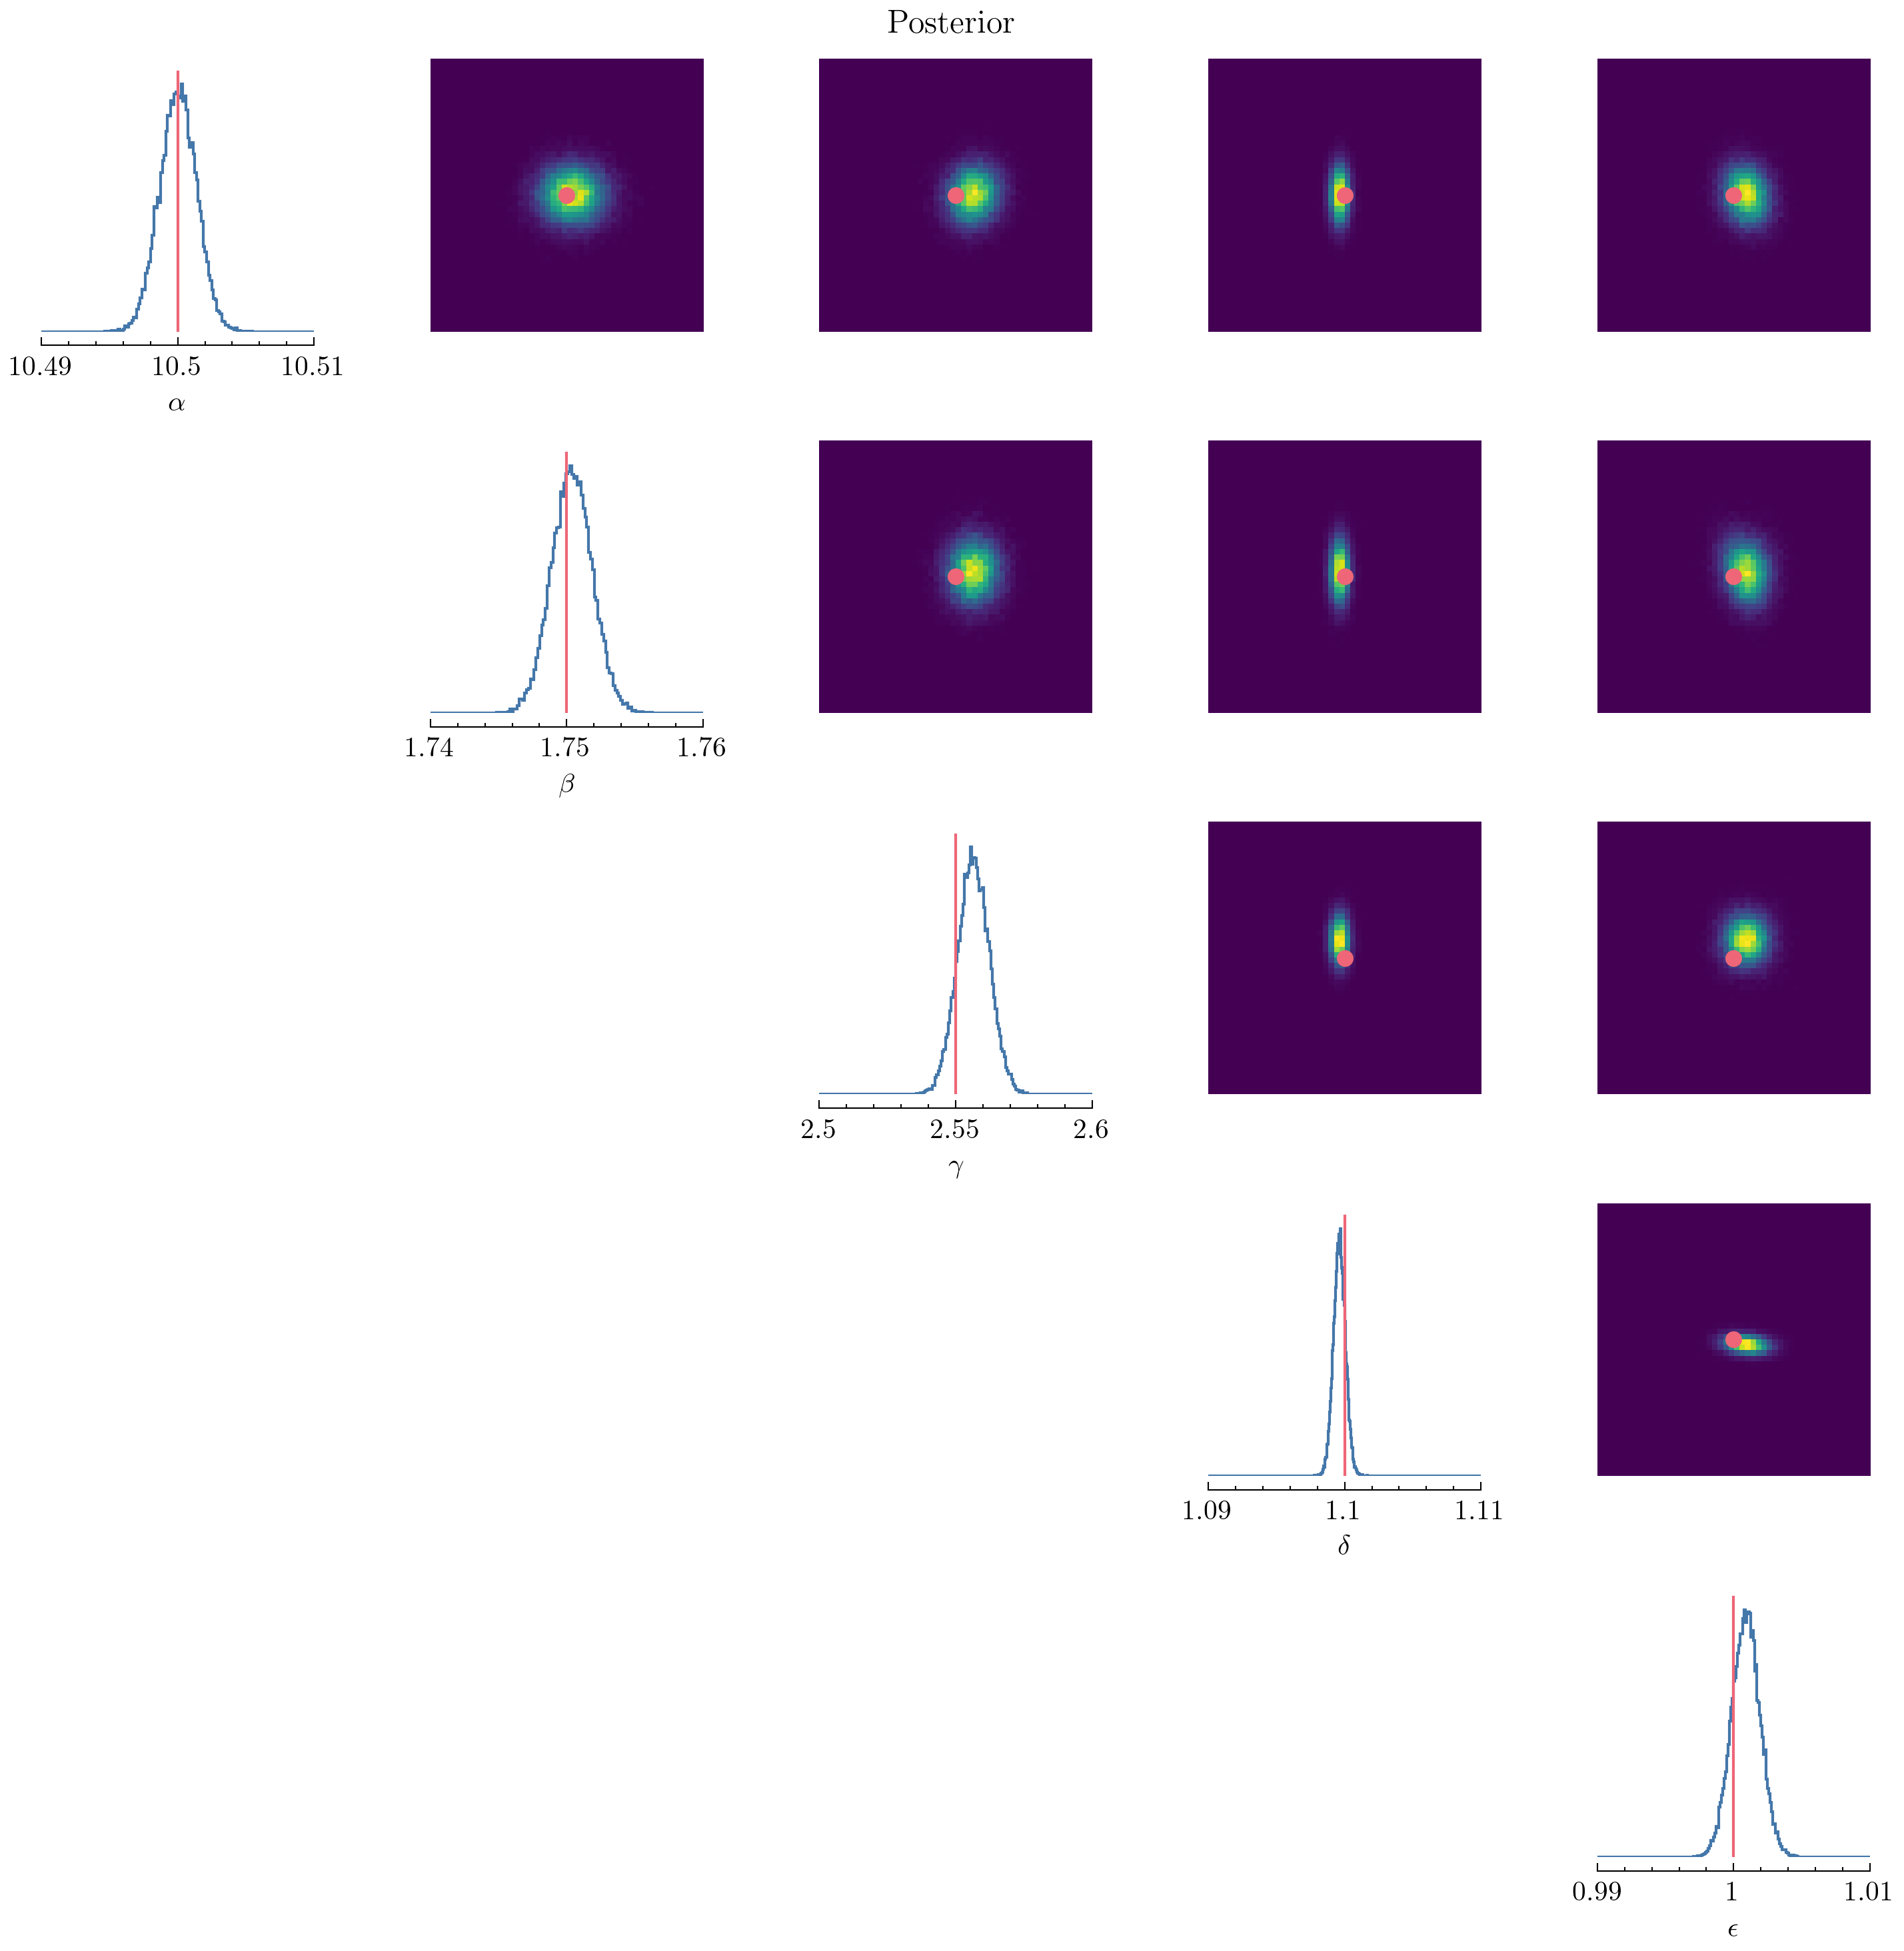

In [ ]:
from src.inference.utils import load_model
from sbi.analysis import pairplot
from sbi.inference import SNPE_C

density_estimator = load_model(os.path.join("..", "results", "synthetic", "model_25000.pkl"))
inference = SNPE_C(prior=prior)

posterior = inference.build_posterior(density_estimator)  
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
x_observed = simulator(true_parameter)
samples = posterior.set_default_x(x_observed).sample((25000,))

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.5-0.01, 10.5+0.01],    
    [1.75-0.01, 1.75+0.01],  
    [2.55-0.05, 2.55+0.05],      
    [1.1-0.01, 1.1+0.01],    
    [1-0.01, 1+0.01],  
])
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

In [ ]:
from sbi.diagnostics import run_tarp
from sbi.inference import SNPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

prior, _, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)

inference = SNPE_C(prior=prior)
posterior = inference.build_posterior(density_estimator)
thetas, xs = simulate_for_sbi(simulator_wrapper, proposal=prior, num_simulations=1000, seed=0)

ecp, alpha = run_tarp(thetas, xs, posterior, references=None, num_posterior_samples=1000)

100%|██████████| 200/200 [00:00<00:00, 3128.96it/s]
Drawing 1000 posterior samples: 1367it [00:27, 50.21it/s]                         


(<Figure size 1800x1800 with 1 Axes>,
 <Axes: xlabel='Credibility Level $\\alpha$', ylabel='Expected Coverage Probability'>)

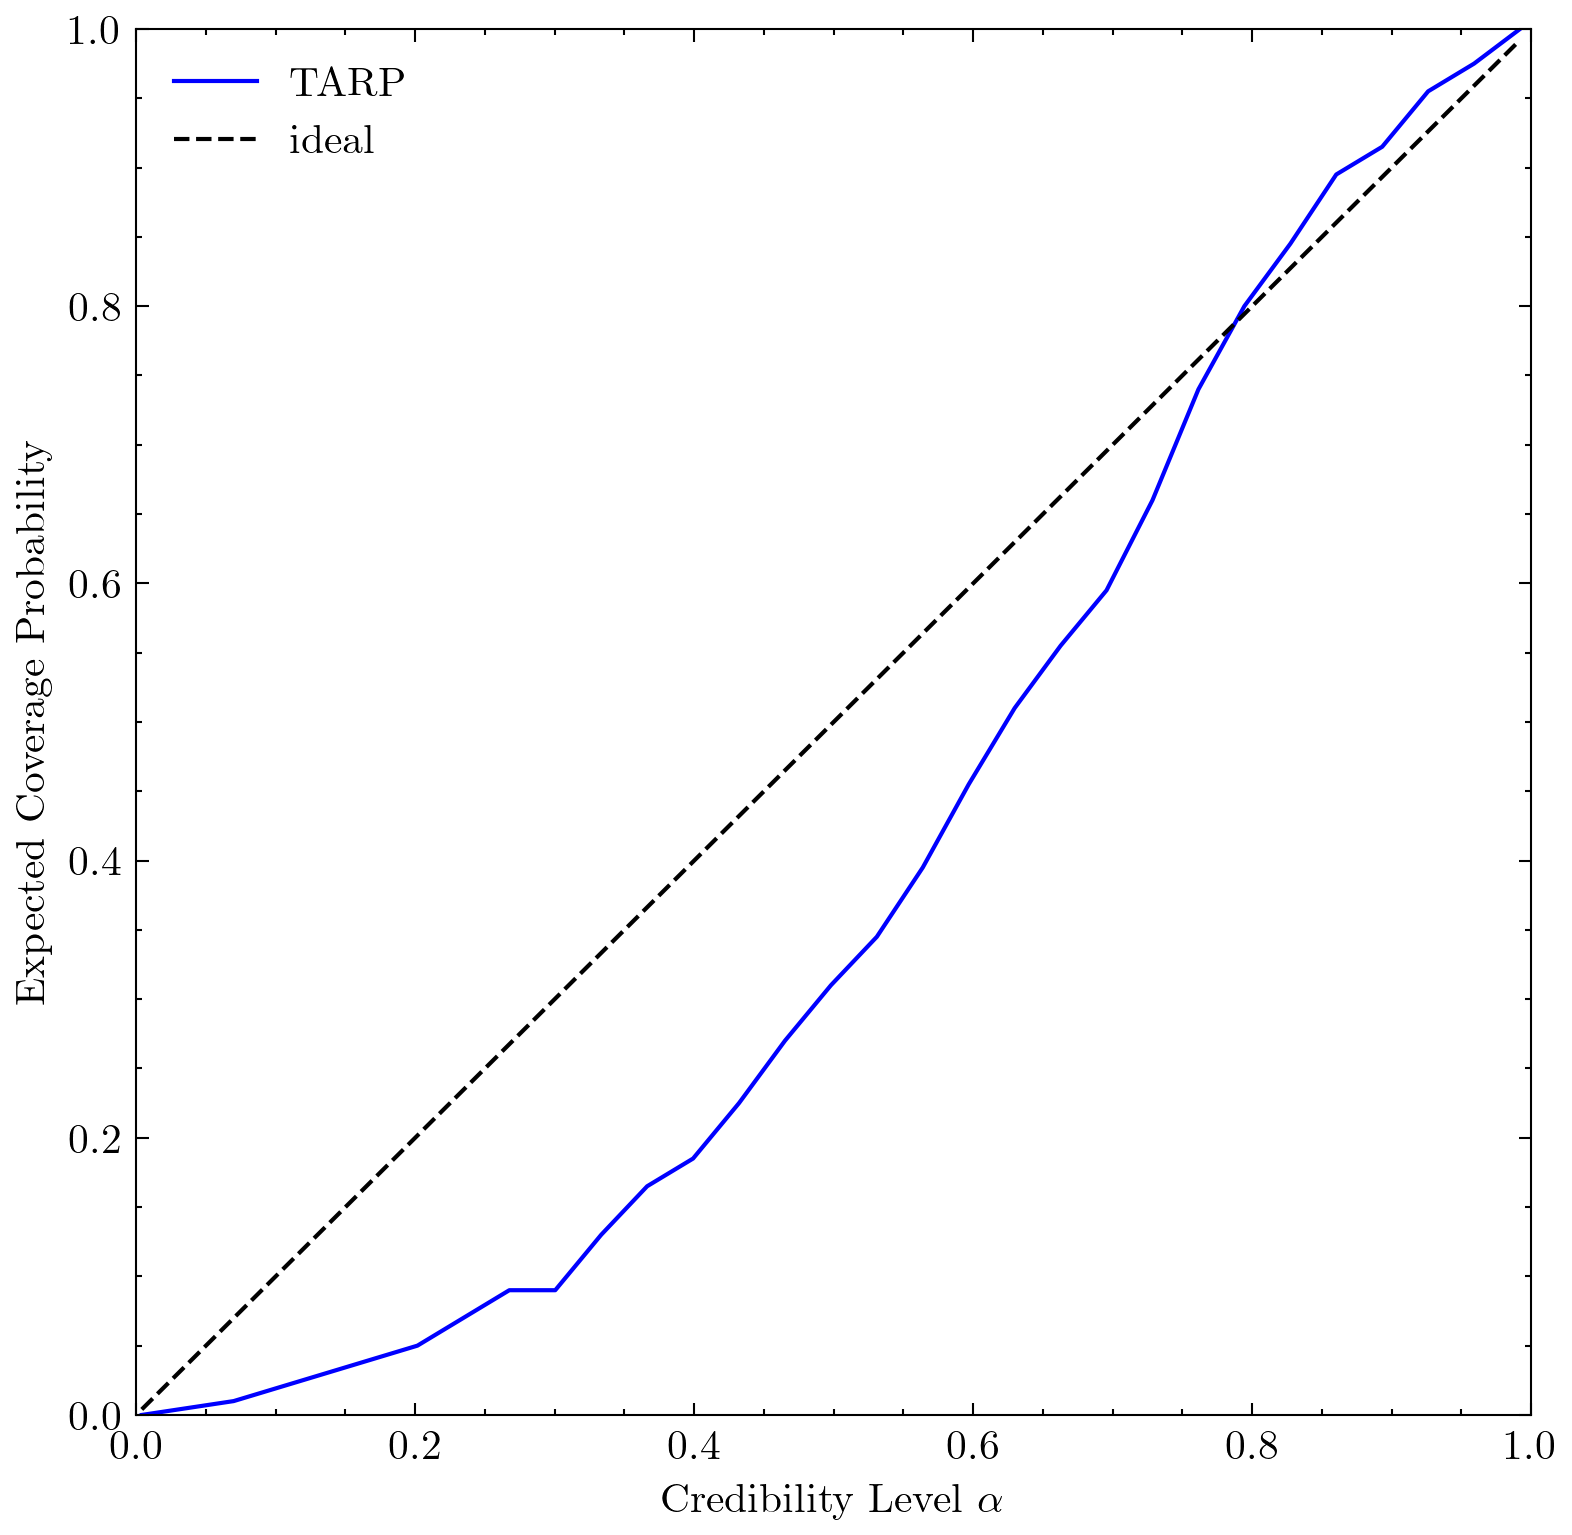

In [ ]:
from sbi.analysis.plot import plot_tarp

plot_tarp(ecp, alpha)